## <b> Problem Statement </b>
**In this project, our task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.**


## <b> Data Description </b>

### <b>Attribute Information: </b>

* **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description:** Product (item) name. Nominal.
* **Quantity:** The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country:** Country name. Nominal, the name of the country where each customer resides.

# **Importing Libraries and Dataset**


In [ ]:
# Importing required libraries
import numpy as np
# To analyze the dataset
import pandas as pd

# For plots and visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer

# For getting optimal number of clusters in hierarchical clustering
from scipy.cluster.hierarchy import dendrogram,linkage
# To scale the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# metrics to evaluate the clusters
from sklearn.metrics import silhouette_score, silhouette_samples
# Clustering alorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# Display utilities
from IPython.display import Markdown, display

# activating DND to disregard the warnings by goiing silent mode
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the dataset
df = pd.read_excel('/content/drive/MyDrive/Customer_Seg_Dataset/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#**Understanding the dataset**

In [ ]:
#Getting shape of dataset
df.shape

(541909, 8)

In [ ]:
#Getting information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Checking all the columns present in the dataset
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#**Data Cleaning**

In [ ]:
# Missing data counts and percentage
missing = df.columns[df.isnull().any()].tolist()

print('Missing Data Count')
print(df[missing].isnull().sum().sort_values(ascending = False))
print('--'*12)
print('Missing Data Percentage')
print(round(df[missing].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
CustomerID     135080
Description      1454
dtype: int64
------------------------
Missing Data Percentage
CustomerID     24.93
Description     0.27
dtype: float64


1. **24.93%** of items purchases are not assigned to any customer
2. Hence there is no use of having the data with no customer assignment.
3.Because we can't form clusters without CustomerID so we will delete them from dataset.

In [ ]:
# Dropping the rows with nulls
df.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
# Dropping the rows with nulls
df.dropna(subset=['Description'], inplace=True)

In [ ]:
# Checking duplicates
print(len(df[df.duplicated()]))

5225


In [ ]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(401604, 8)

In [ ]:
# Getting the unique values from different features
df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [ ]:
# InvoiceNo starting with 'C' represents cancellation
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
cancellations = df[df['InvoiceNo'].str.contains('C')]
cancellations.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [ ]:
cancellations.shape

(8872, 8)

In [ ]:
#Getting unique value from cancelled data
cancellations.nunique()

InvoiceNo      3654
StockCode      1920
Description    1945
Quantity        134
InvoiceDate    3586
UnitPrice       376
CustomerID     1589
Country          28
dtype: int64

we have to drop some  InvoiceNo  which are starts with 'c' because 'c', it indicates a cancellation

In [ ]:
#Print the percentage of cancelled product
cancel_product = cancellations['InvoiceNo'].value_counts().sum()
total_product = df['InvoiceNo'].value_counts().sum()
print("Number of cancelled products data", cancel_product,
      'Percentage of cancelled data',(cancel_product*100/total_product), "\n")

Number of cancelled products data 8872 Percentage of cancelled data 2.209141343213713 



In [ ]:
# Dropping cancellations from the main dataframe
df = df[~df['InvoiceNo'].str.contains('C')]

In [ ]:
# checking null counts and datatype in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


##**Feature Engineering**

In [ ]:
# Creating new features from the datetime column InvoiceDate
df["year"]  = df["InvoiceDate"].apply(lambda x: x.year)
df['Month'] = df['InvoiceDate'].apply(lambda x: x.month_name())
df['Day']   = df['InvoiceDate'].apply(lambda x: x.day_name())
df["hour"]  = df["InvoiceDate"].apply(lambda x: x.hour)

In [ ]:
# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
df['TotalAmount'] = round((df['Quantity']*df['UnitPrice']),2)

In [ ]:
# Creating a new feature 'TimeType' based on hours to define whether its Morning,Afternoon or Evening
df['TimeType'] = np.where((df["hour"] >= 5) & (df["hour"] < 12), 'Morning',
                         np.where((df["hour"] >= 12) & (df["hour"] < 18), 'Afternoon', 'Evening'))

In [ ]:
#getting info of data
print(df.columns)
df.nunique()

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'year', 'Month', 'Day', 'hour',
       'TotalAmount', 'TimeType'],
      dtype='object')


InvoiceNo      18536
StockCode       3665
Description     3877
Quantity         302
InvoiceDate    17286
UnitPrice        441
CustomerID      4339
Country           37
year               2
Month             12
Day                6
hour              15
TotalAmount     2699
TimeType           3
dtype: int64

#**Exploratory Data Analysis**

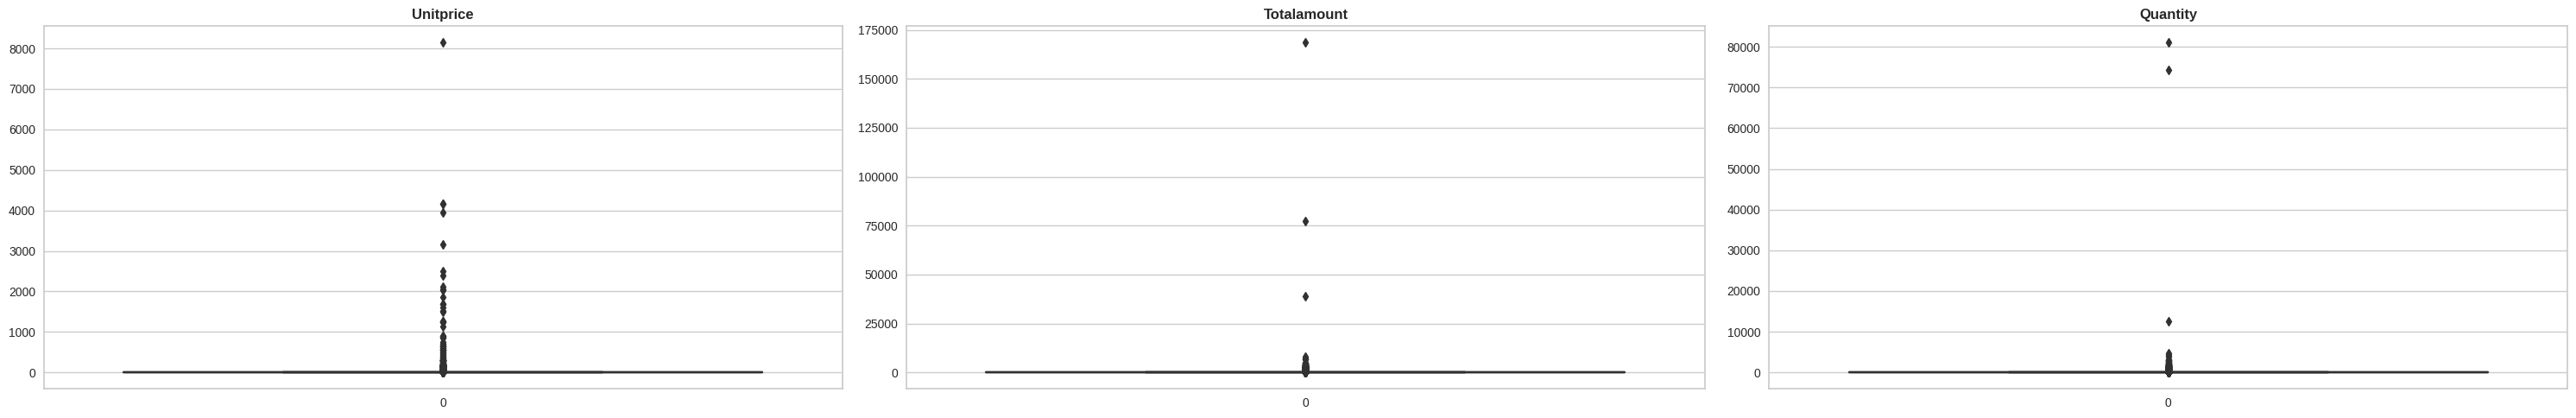

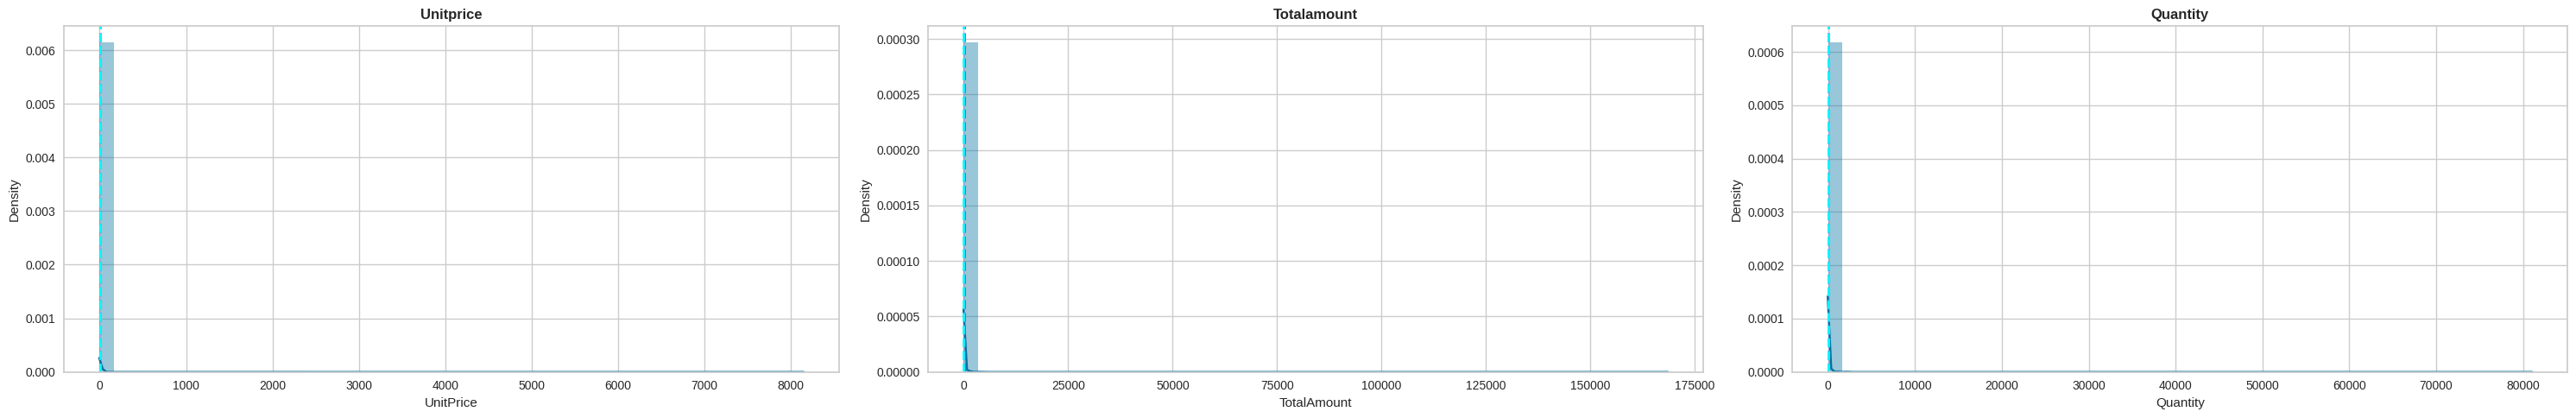

In [ ]:
# Visualization of the outliers.
plt.figure(figsize=(30,5))
for n,column in enumerate(['UnitPrice','TotalAmount','Quantity']):
  plt.subplot(1, 3, n+1)
  sns.boxplot(df[column])
  plt.title(f'{column.title()}',weight='bold')
  plt.tight_layout();

# Visualizing the distributions.
plt.figure(figsize=(30,5))
for n,column in enumerate(['UnitPrice','TotalAmount','Quantity']):
  plt.subplot(1, 3, n+1)
  sns.distplot(df[column])
  plt.axvline(df[column].mean(), color='magenta', linestyle='dashed', linewidth=2)
  plt.axvline(df[column].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.title(f'{column.title()}',weight='bold')
  plt.tight_layout();

* From above plot, we can see that, there are so many outliers in the Unitprice, Total Amount, Quantity. hence the distribution is highly positively skewed.
* We can conclude that, the price and purchased quantity vary so much.

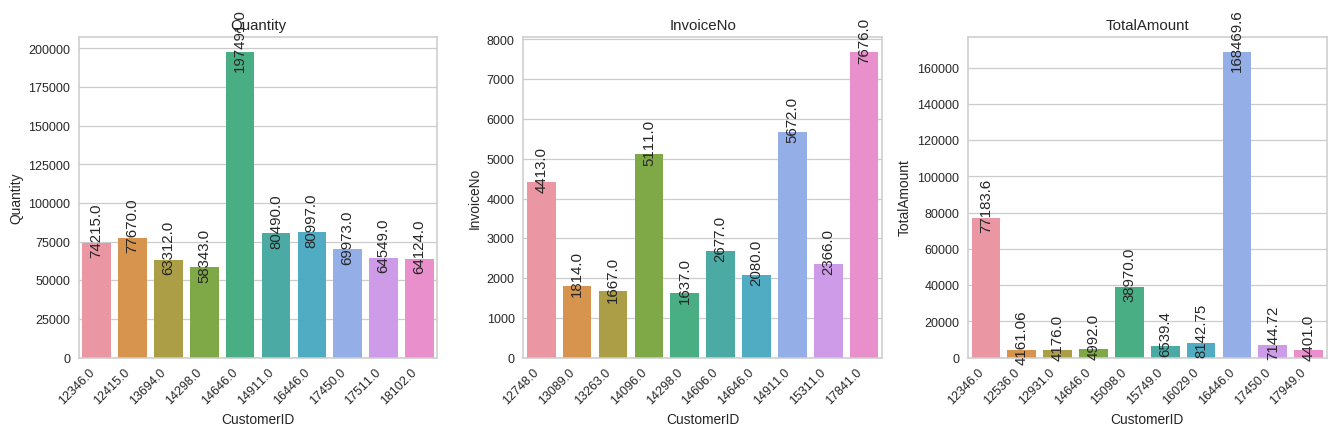

In [ ]:
#Getting those customer which purchased in bulk quantity, frequntly, and the highest purchasing power
customers = df.groupby(['CustomerID']).agg({'Quantity':'sum','InvoiceNo':'count','TotalAmount':'max'}).reset_index()

plt.figure(figsize=(15,5),dpi=90)
for n,i in enumerate(['Quantity','InvoiceNo','TotalAmount']):
  plt.subplot(1,3,n+1)
  plt.xticks(rotation=45,ha='right')
  plt.title(f'{i}')
  df0 = sns.barplot(data=customers.sort_values(i,ascending=False).head(10),x="CustomerID",y=i)
  for i in df0.patches:
    df0.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10),rotation=90, textcoords = 'offset points')
  plt.tight_layout();

**Q. What insights we get from above chart?**
  * **top 10 customers who purchased in bulky quantity:** 12346, 12415, 13694, 14298, 14646, 14911, 16446, 17450, 17511, 18102
  * **top 10 customers who generated highest invoices:** 12748, 13089, 13263, 14096, 14298, 14606, 14646, 14911, 15311, 17841
  * **top 10 customers who purchased highest amount of products:** 16446, 12346, 15098, 12536, 12931, 14646, 15749, 16029, 17450, 17949

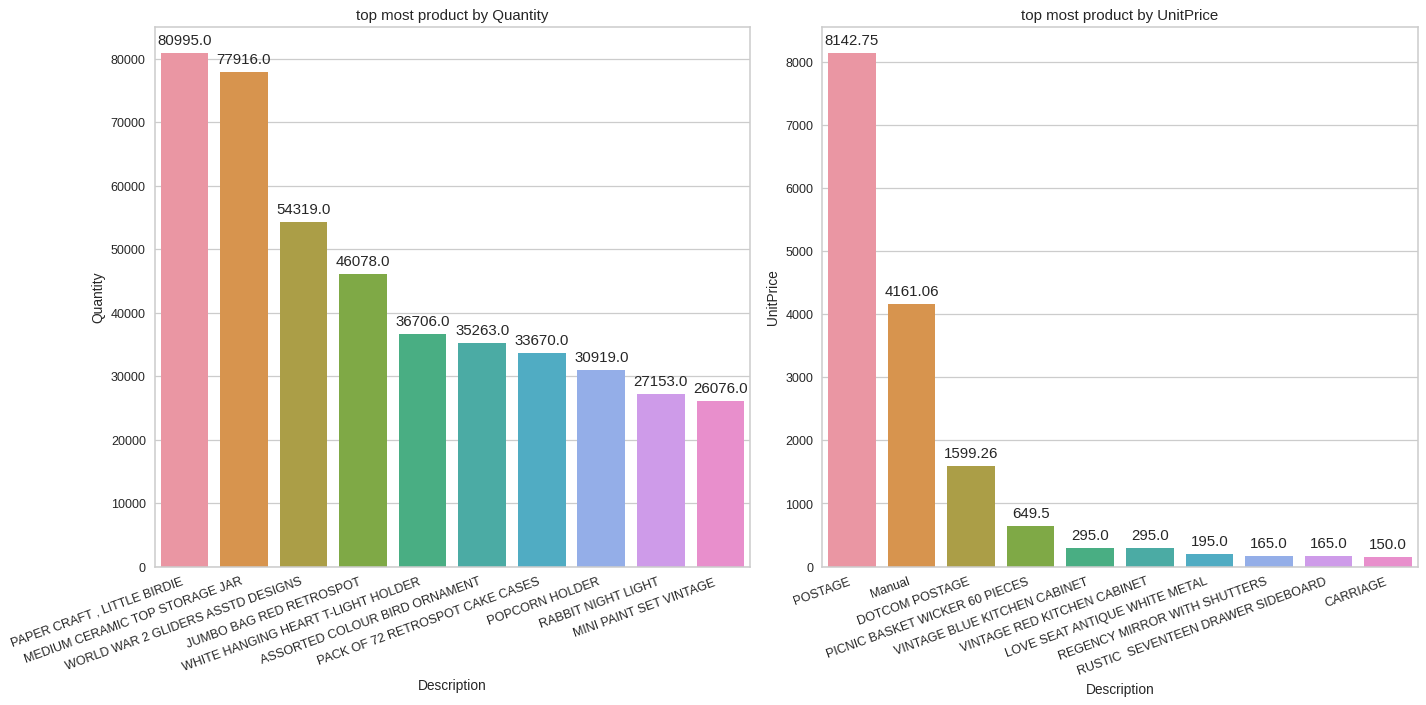

In [ ]:
# Getting the product which are purchased in bulk and in minimum bulk
Price = df.groupby(['Description','StockCode']).agg({'Quantity':'sum','UnitPrice':'max'}).reset_index()

plt.figure(figsize=(16,8),dpi=90)
for n,i in enumerate(['Quantity','UnitPrice']):
  plt.subplot(1,2,n+1)
  plt.xticks(rotation=20,ha='right')
  plt.title(f'top most product by {i}')
  df0 = sns.barplot(data=Price.sort_values(i,ascending=False).head(10),x="Description",y=i)
  for i in df0.patches:
    df0.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  plt.tight_layout();

**Q. What insights we get from above chart?**
  * **top 10 products which are purchased in bulk:** Paper craft, medium ceramic top storage jar, jumbo bag red retrospot, etc
  * **top 10 products which have highest price:** Postage, Manual, Dotcom Postage, Picnic basket wicker 60 pieces, vintage red kitchen cabinet, etc.

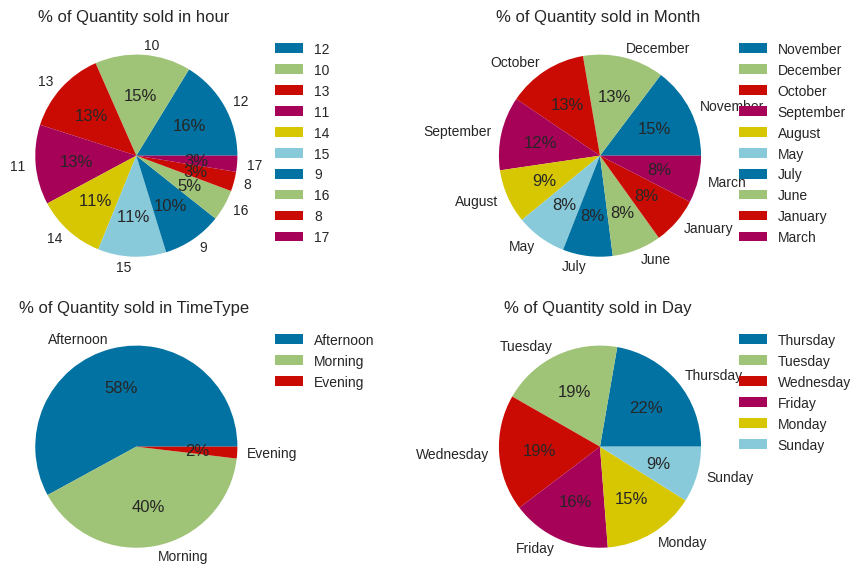

In [ ]:
# Getting the % of quantity of product purchased in hour, month, timetype, days
plt.figure(figsize=(10,6))
for n,i in enumerate(['hour','Month','TimeType','Day']):
    plt.subplot(2,2,n+1)
    group = df.groupby([i]).agg({'Quantity':'sum','InvoiceNo':'count'}).reset_index().sort_values('Quantity',ascending=False).head(10)
    # plotting data on chart
    plt.pie(group['Quantity'],labels=group[i],autopct='%.0f%%',shadow=False)
    plt.title(f'% of Quantity sold in {i} ')
    plt.legend(group[i],loc='best',bbox_to_anchor=(1,1))
    plt.tight_layout();

**Q. What insights we get from above piechart?**
* Highest % of quantity sold in 12th, 10th, 13th, 11th, 14th Hour and least in 17th, 3rd, 16th hour.most of retailer are active between 10 a.m. to 2 p.m.
* Highest % of quantity sold in November, December, October, September. Since these months are near to christmas, many retailer buys in this month. least sold in April, January, February, March month.
* Highest % of quantity sold in Afternoon, then in Morning.
* Highest % of quantity sold on Thursday, Tuesday, Wednesday, Friday. On saturday no one purchased. we can say that Saturday is a Holiday for them.

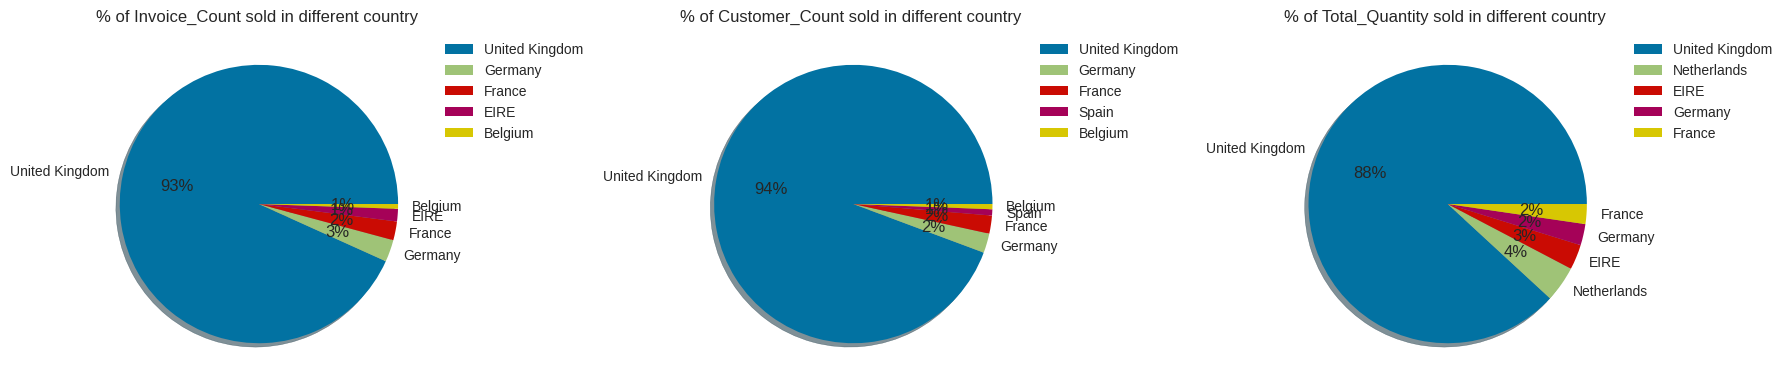

In [ ]:
# Most orders placed are from these countries
# Most customers are from these countries
# Countrywise total item purchases
country = df.groupby("Country").agg({'InvoiceNo':'nunique','CustomerID':'nunique','Quantity':'sum'}).reset_index()
country.rename(columns={'InvoiceNo': 'Invoice_Count','CustomerID': 'Customer_Count','Quantity':'Total_Quantity'}, inplace=True)

# Getting the % of Invoices, customers, and quantity by country
plt.figure(figsize=(18,6))
for n,i in enumerate(['Invoice_Count','Customer_Count','Total_Quantity']):
    plt.subplot(1,3,n+1)
    df1 = country.sort_values(i,ascending=False).head()
    # plotting data on chart
    plt.pie(df1[i],labels=df1['Country'],autopct='%.0f%%',shadow=True)
    plt.title(f'% of {i} sold in different country ')
    plt.legend(df1['Country'],loc='best',bbox_to_anchor=(1,1))
    plt.tight_layout();

* **Highest invoices is generated from United Kingdom.**
* **United Kingdom has the highest number of customers.**
* **Orders with mass quantity are placed from the United Kingdom.**

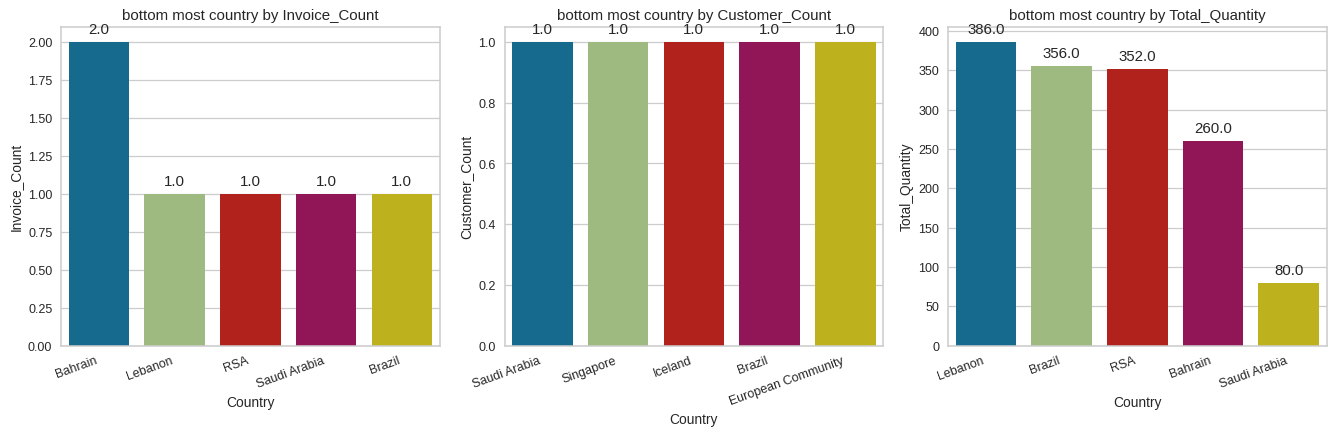

In [ ]:
# Least orders placed are from these countries
# Least customers are from these countries
# Countrywise least total item purchases
plt.figure(figsize=(15,5),dpi=90)
for n,i in enumerate(['Invoice_Count','Customer_Count','Total_Quantity']):
  plt.subplot(1,3,n+1)
  plt.xticks(rotation=20,ha='right')
  plt.title(f'bottom most country by {i}')
  df2 = sns.barplot(data=country.sort_values(i,ascending=False).tail(),x="Country",y=i)
  for i in df2.patches:
    df2.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  plt.tight_layout();

* **Least invoices is generated from Brazil, Saudi Arabia, RSA, Lebonan.**
* **European Community, Brazil, Iceland, Singapore, Saudi Arabia has the least number of customers.**
* **Orders with least quantity are placed from the Saudi Arabia, Bahrain, RSA, Brazil, Lebanon.**

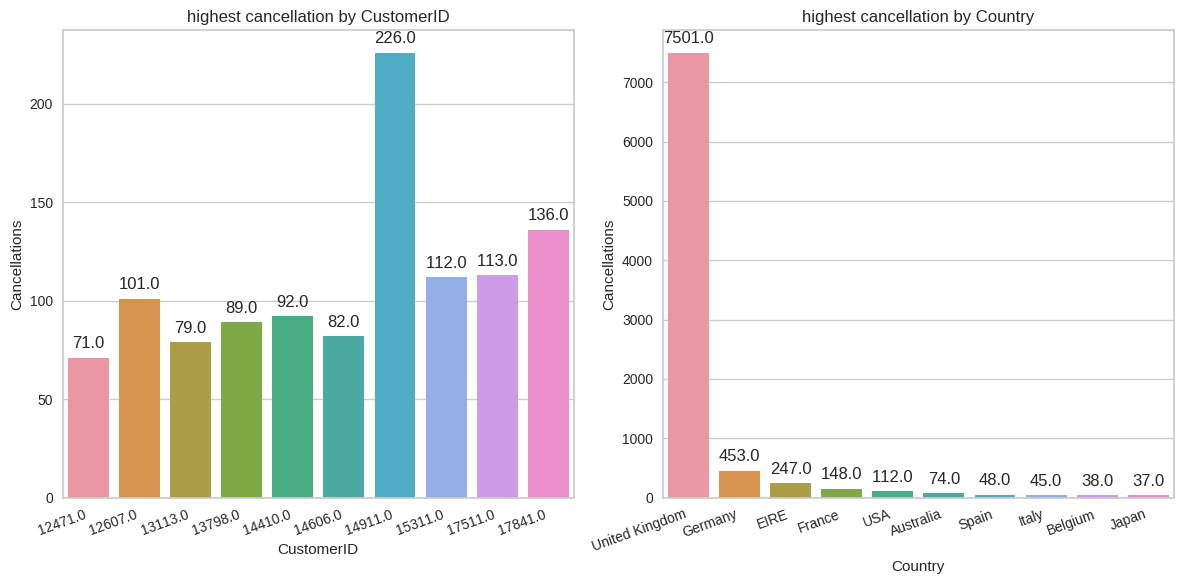

In [ ]:
# Checking the number of cancellations by each customer.
plt.figure(figsize=(12,6))
for n,i in enumerate(['CustomerID','Country']):
  customer_cancellations = cancellations.groupby(i).count()['InvoiceNo'].reset_index().sort_values("InvoiceNo",ascending=False)
  customer_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
  plt.subplot(1,2,n+1)
  plt.xticks(rotation=20,ha='right')
  plt.title(f'highest cancellation by {i}')
  df3 = sns.barplot(data=customer_cancellations.head(10),x=i,y='Cancellations')
  for i in df3.patches:
    df3.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  plt.tight_layout();

**Q. What insights we get from above piechart?**
* Most of products are cancelled from above countries: United Kingdom, Germany, EIRE, France, USA, Australia, Spain, etc.
* Customer who cancelled highest number of products: 14911, 17841, 17511, 15311, 12607, etc.

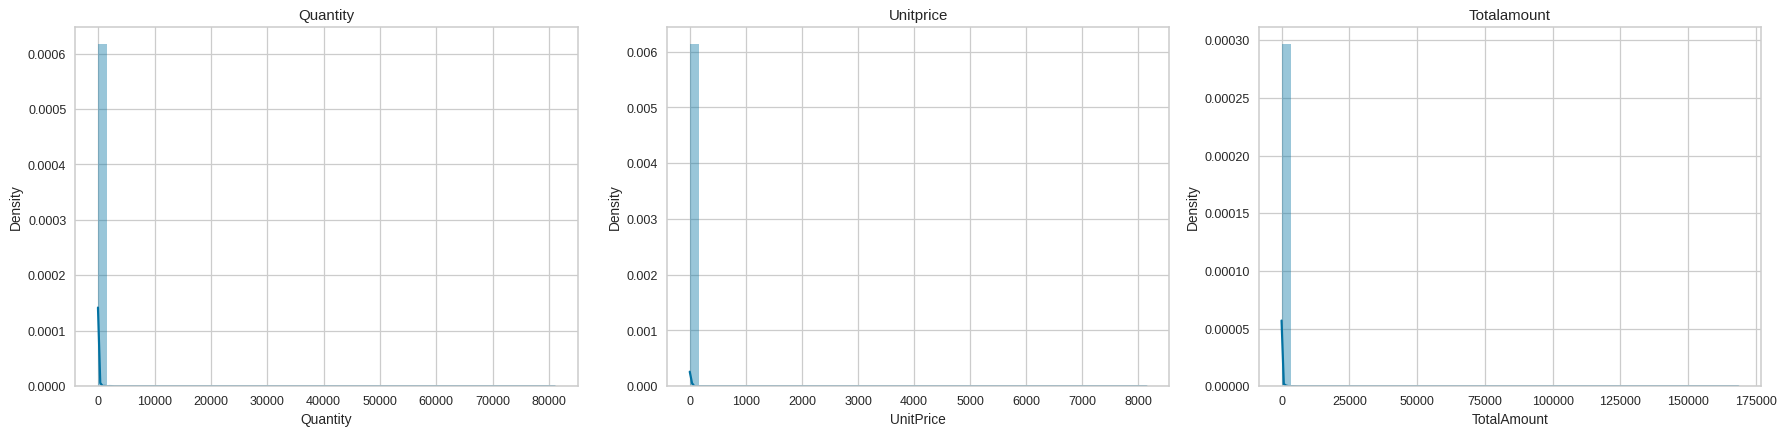

In [ ]:
# Visualizing the distributions.
target = ['Quantity','UnitPrice','TotalAmount']
plt.figure(figsize=(20,5), dpi=90)
for n,col in enumerate(target):
  plt.subplot(1, 3, n+1)
  sns.distplot(df[col])
  plt.title(col.title())
  plt.tight_layout()

Observation:
1. It shows a positively skewed distribution because most of the values are clustered around the left side of the distribution while the right tail of the distribution is longer, which means mean>median>mode
2. For symmetric graph mean=median=mode.

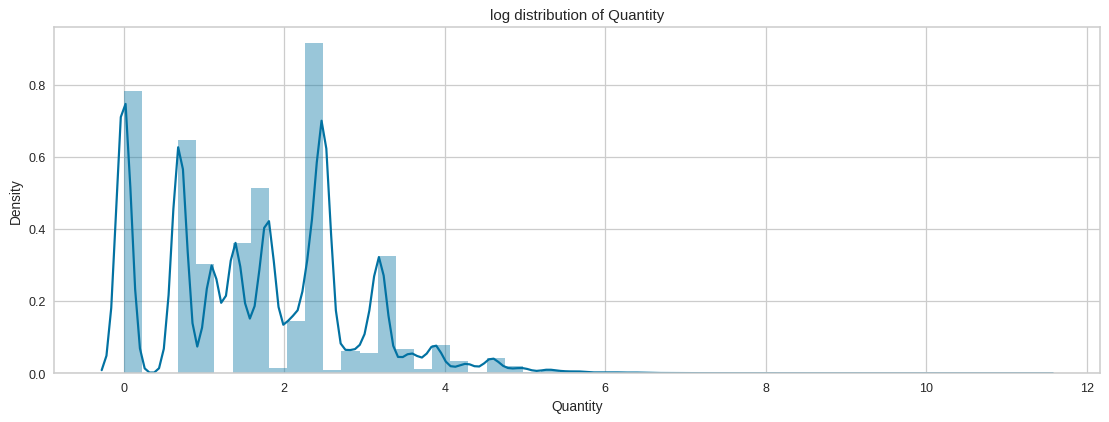

In [ ]:
# Visualizing the distributions after log transformation of Quantity
plt.figure(figsize=(15,5), dpi=90)
plt.title('log distribution of Quantity')
sns.distplot(np.log(df['Quantity']))
plt.show();

* Since Most of the Customers are wholesalers we cannot group customers based on the demographic group like age, gender, income and behavioral and psycho-graphic group Because Our Customers purchase bunch of goods from us and sell it to individual customers.
* We only need to deal issues and make clusters related to B2B Business to Business instead of B2C i.e. Direct from Business to Customers
People who purchase products from us, do not utilize it. They sell it to individual customers(B2C) or sell all products to another stores (B2B)
* Due to all these reasons we need to cluster customers according to there activities i.e
  1. R- Recency
  2. F- Frequency
  3. M- Monetary


# **RFM Modelling:**
Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. **The RFM model is based on three quantitative factors:**
* Recency: How recently a customer has made a purchase.
* Frequency: How often a customer makes a purchase.
* Monetary Value: How much money a customer spends on purchases.

**Calculating RFM scores**

The number is typically 3 or 5. If you decide to code each RFM attribute into 3 categories, you'll end up with 27 different coding combinations ranging from a high of 333 to a low of 111. Generally speaking, **the higher the RFM score, the more valuable the customer.**

In [ ]:
# Adding 1 day to the Last Invoice date to set as Latest date for reference
LatestDate = df["InvoiceDate"].max() + pd.DateOffset(days=1)

# Creating a new dataframe to calculate Recency, Frequency and Monetary scores for each customer
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (LatestDate - x.max()).days,   #how many days ago the customer purchased,
                                    'InvoiceNo': lambda x: len(x),    #how often the customer purchased
                                    'TotalAmount': lambda x: x.sum()})     #how much money the customer spends on purchase

# Renaming the columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)

# Checking top 5 rows
rfm.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


Interpretation:
1. Recency: How recent a customer made a purchase.
2. Frequency: How often a customer makes a purchase.
3. Monetary: How much money a customer spends.

In [ ]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [ ]:
# Calculating R, F and M scores by splitting Recency, Frequency	and Monetary based on quantiles
rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=[1,2,3,4]).astype(int)

# Finding the RFM Group for each customer by combining the factors R,Fand M
rfm['RFM'] = 100*rfm['R'] + 10*rfm['F'] + rfm['M']

Interpretation:
1. If the RFM of any customer is 444. His Recency is good, frequency is more and Monetary is more. So, he is the best customer.
2. If the RFM of any customer is 111. His Recency is low, frequency is low and Monetary is low. So, he is the churning customer.
3. If the RFM of any customer is 144. He purchased a long time ago but buys frequently and spends more. And so on.
4. Like this we can come up with number of segments for all combinations of R,F and M base on our usecase. Higher the RFM score, more valuable the customer is.

In [ ]:
# Handling the zeroes in the dataframe to avoid error in transformations
rfm.replace(0.0,1,inplace=True)

# Applying Log transformation on columns for smoothening the distribution
rfm['Recency_Log']   = rfm['Recency'].apply(np.log)
rfm['Frequency_Log'] = rfm['Frequency'].apply(np.log)
rfm['Monetary_Log']  = rfm['Monetary'].apply(np.log)
rfm.head()

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,R,F,M,RFM
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,5.786897,0.000000,11.253942,1,1,4,114
12347.0,2,182,4310.00,0.693147,5.204007,8.368693,4,4,4,444
12348.0,75,31,1797.24,4.317488,3.433987,7.494007,2,2,4,224
12349.0,19,73,1757.55,2.944439,4.290459,7.471676,3,3,4,334
12350.0,310,17,334.40,5.736572,2.833213,5.812338,1,1,2,112


In [ ]:
# Assigning a title to a customer.
# Platinum corresponds to highest range of RFM score down to Bronze to lowest range of RFM score.

rfm['customer_title'] = pd.qcut(rfm['RFM'], 4, ['Bronze','Silver','Gold','Platinum'])
rfm.head()

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,R,F,M,RFM,customer_title
CustomerID,,,,,,,,,,,
12346.0,326,1,77183.60,5.786897,0.000000,11.253942,1,1,4,114,Bronze
12347.0,2,182,4310.00,0.693147,5.204007,8.368693,4,4,4,444,Platinum
12348.0,75,31,1797.24,4.317488,3.433987,7.494007,2,2,4,224,Silver
12349.0,19,73,1757.55,2.944439,4.290459,7.471676,3,3,4,334,Gold
12350.0,310,17,334.40,5.736572,2.833213,5.812338,1,1,2,112,Bronze


In [ ]:
# Checking Descriptive Stats
rfm.describe().round(2)

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,R,F,M,RFM
count,4339.00,4339.00,4339.00,4339.00,4339.00,4339.00,4339.00,4339.00,4339.00,4339.00
mean,92.52,90.51,2048.22,3.77,3.67,6.58,2.51,2.49,2.50,278.79
std,100.01,225.52,8984.25,1.43,1.32,1.27,1.13,1.12,1.12,118.83
min,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,111.00
25%,18.00,17.00,306.46,2.89,2.83,5.73,2.00,1.00,1.50,211.00
50%,51.00,41.00,668.56,3.93,3.71,6.51,3.00,2.00,2.00,311.00
75%,142.00,98.00,1660.32,4.96,4.58,7.41,4.00,3.00,3.50,411.00
max,374.00,7676.00,280206.02,5.92,8.95,12.54,4.00,4.00,4.00,444.00


##**Creating a Detail Customer title / tag based on RFM Score**

An extended version of customer title is made which divides the entire number of customers into 11 groups. The groups are mainly Platinum Customers, Very Loyal, Becoming Loyal, Recent Customers, Potential Customers, Late Bloomer, Loosing Customers, High Risk Customers, Almost Lost Customers, Evasive Customers and Lost Customers.

In [ ]:
# Function as a lookup to appropiate customer titles based on RFM score.

def cust_category(cols):

    rfm_score = cols[0]

    if rfm_score >= 444:
        return 'Platinum Customer'
    elif rfm_score >=433 and rfm_score < 444:
        return 'Very Loyal'
    elif rfm_score >=421 and rfm_score < 433:
        return 'Becoming Loyal'
    elif rfm_score >=344 and rfm_score < 421:
        return 'Recent Customer'
    elif rfm_score >=323 and rfm_score < 344:
        return 'Potential Customer'
    elif rfm_score >=311 and rfm_score < 323:
        return 'Late Bloomer'
    elif rfm_score >=224 and rfm_score < 311:
        return 'Loosing Customer'
    elif rfm_score >=212 and rfm_score < 224:
        return 'High Risk Customer'
    elif rfm_score >=124 and rfm_score < 212:
        return 'Almost Lost Customer'
    elif rfm_score >=111 and rfm_score < 124:
        return 'Evasive Customer'
    else :
        return 'Lost Customer'

In [ ]:
# Applying the above functions and creating a new feature detail_cust_title

rfm['detail_cust_title']=rfm[['RFM']].apply(cust_category, axis=1)

In [ ]:
rfm.head()

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,R,F,M,RFM,customer_title,detail_cust_title
CustomerID,,,,,,,,,,,,
12346.0,326,1,77183.60,5.786897,0.000000,11.253942,1,1,4,114,Bronze,Evasive Customer
12347.0,2,182,4310.00,0.693147,5.204007,8.368693,4,4,4,444,Platinum,Platinum Customer
12348.0,75,31,1797.24,4.317488,3.433987,7.494007,2,2,4,224,Silver,Loosing Customer
12349.0,19,73,1757.55,2.944439,4.290459,7.471676,3,3,4,334,Gold,Potential Customer
12350.0,310,17,334.40,5.736572,2.833213,5.812338,1,1,2,112,Bronze,Evasive Customer


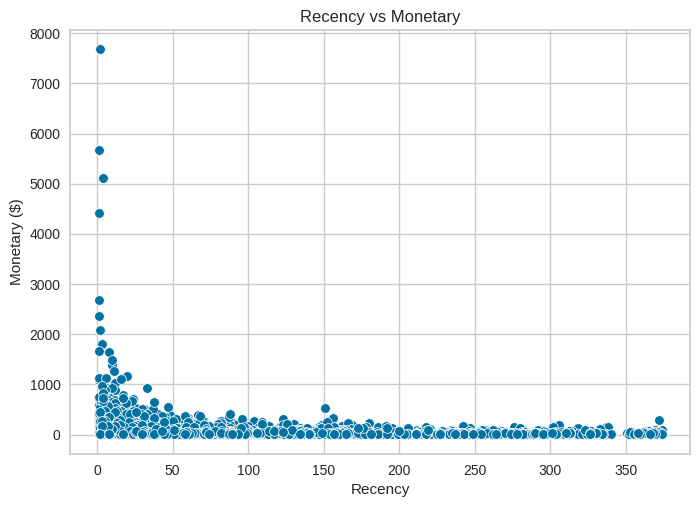

In [ ]:
#Recency vs Monetary
sns.scatterplot(data=rfm, x="Recency", y="Frequency")
plt.xlabel('Recency')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary')
plt.show()

The chart shows that customers who purchased recently generated more revenue than customers who visited long time ago. Customers from recent past (0-50) days generated a more revenue. Customers who visited 100 or more days ago generated a low revenue.

In [ ]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary', 'Recency_Log', 'Frequency_Log',
       'Monetary_Log', 'R', 'F', 'M', 'RFM', 'customer_title',
       'detail_cust_title'],
      dtype='object')

In [ ]:
#Customer Segment Distribution
# Calculating the number of unique customers under a customer title.

cust_per_title = rfm[['detail_cust_title']].groupby('detail_cust_title').size().reset_index(name='Number of Customers')

In [ ]:
cust_per_title.sort_values(by=['Number of Customers'],ascending=False)

,detail_cust_title,Number of Customers
2,Evasive Customer,865
7,Potential Customer,481
5,Loosing Customer,463
6,Platinum Customer,450
3,High Risk Customer,424
0,Almost Lost Customer,398
4,Late Bloomer,365
9,Very Loyal,336
8,Recent Customer,328
1,Becoming Loyal,229


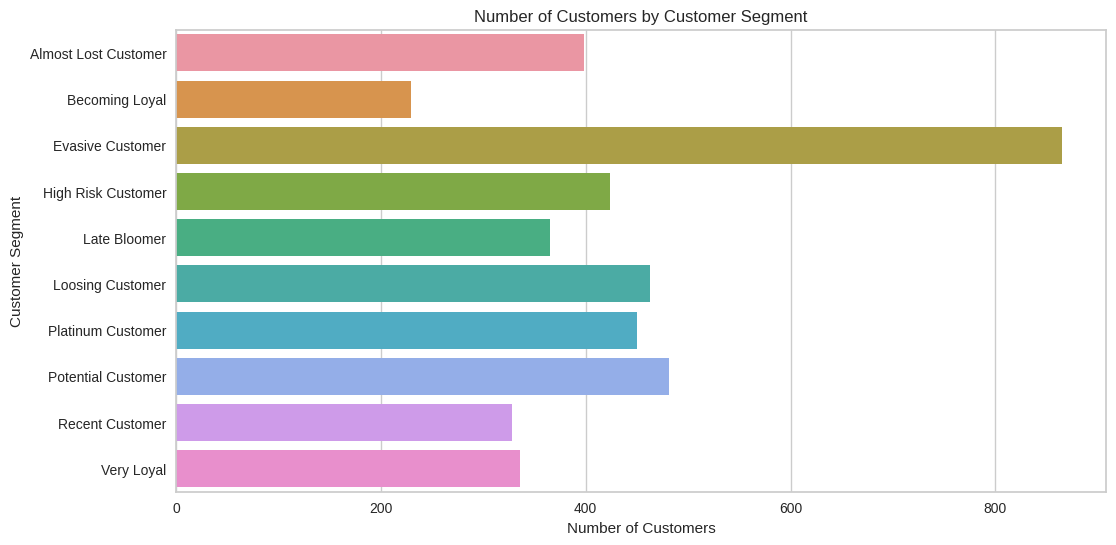

In [ ]:
# Plotting the Number of Customers

plt.figure(figsize=(12,6))
sns.barplot(y='detail_cust_title' , x='Number of Customers', data=cust_per_title)
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')
plt.title('Number of Customers by Customer Segment')
plt.show()

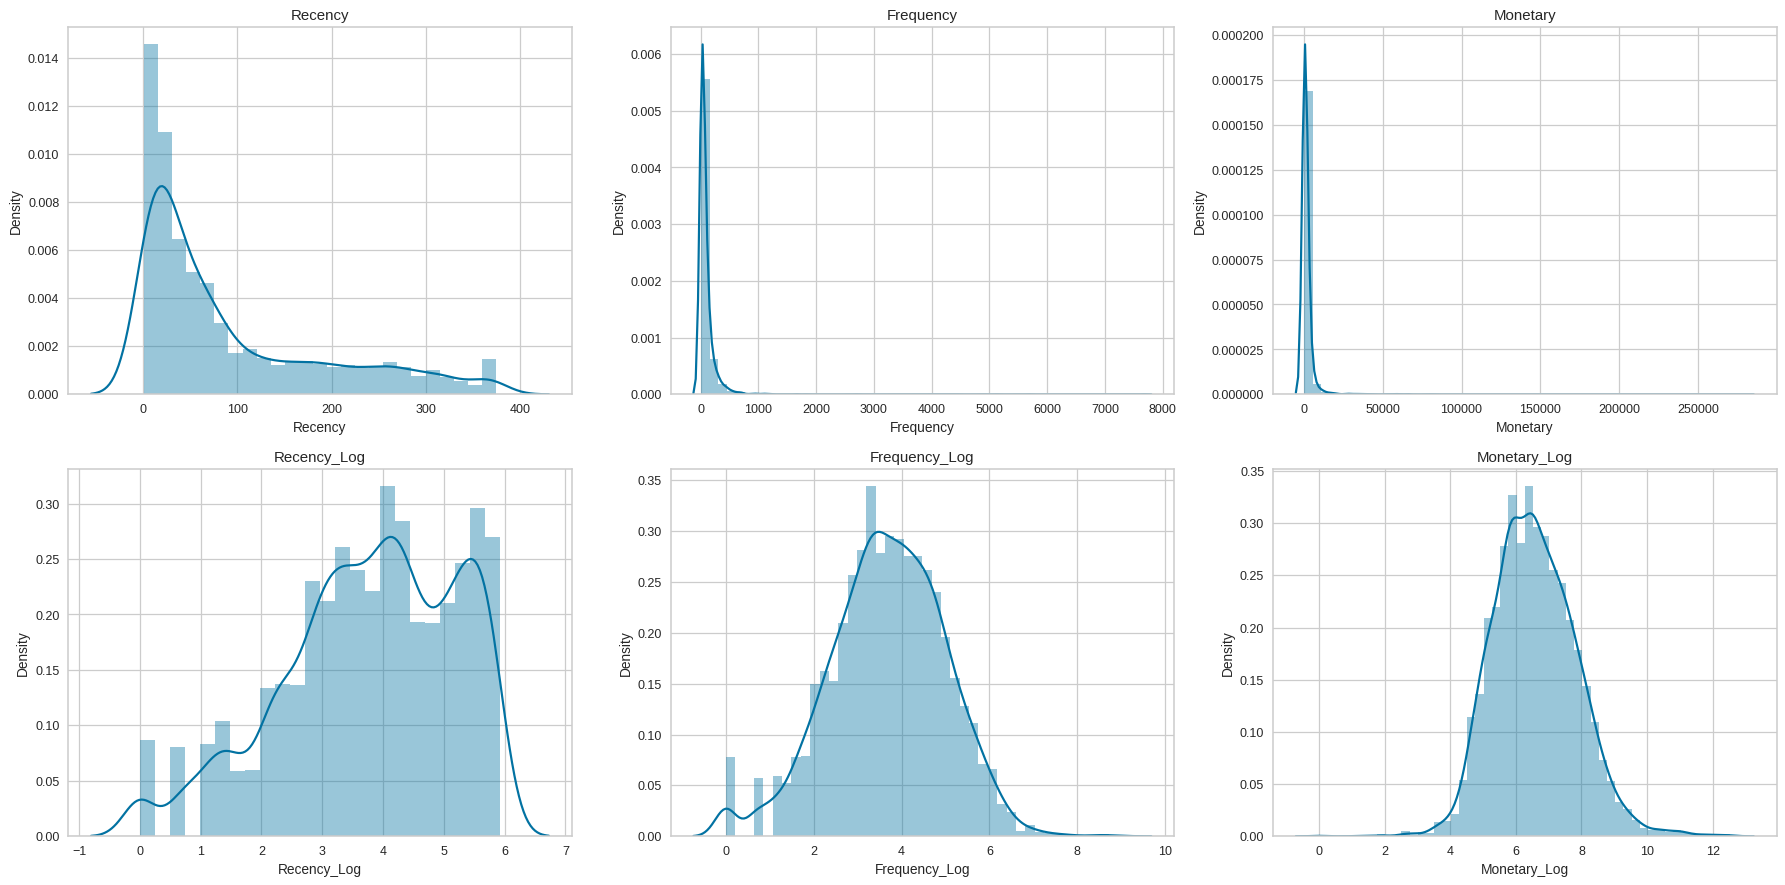

In [ ]:
# Visualizing the distributions before and after log transformation.
target = ['Recency', 'Frequency',	'Monetary', 'Recency_Log', 'Frequency_Log', 'Monetary_Log']
plt.figure(figsize=(20,10), dpi=90)
for n,col in enumerate(target):
  plt.subplot(2, 3, n+1)
  sns.distplot(rfm[col])
  plt.title(col.title())
  plt.tight_layout()

Observations:
1. Earlier the distributions of Recency, Frequency and Monetary columns were positively skewed but after applying log transformation, the distributions appear to be symmetrical and normally distributed.
2. It will be more suitable to use the transformed features for better visualisation of clusters.

#**Clustering**

##**Prerequisites**

In [ ]:
# Defining X Variables
X = rfm[['Recency_Log','Frequency_Log','Monetary_Log']]
X = StandardScaler().fit_transform(X)

In [ ]:
# Initializing an empty dictionary to store the stats and summary for all clusters
conclusion={}

# Definin a function to remove the outliers
def cap_outliers(col,overlap_supress):
  '''
    Takes a column and removes the outliers based on the overlap_supress value
    col: column to be cleaned
    overlap_supress: value to be used to remove the outliers
    Type:
    col: pandas.Series
    overlap_supress: float

    Returns:Capped column with outliers removed
  '''
  condition1=col < col.quantile(1-overlap_supress)
  condition2=col > col.quantile(overlap_supress)
  return col[condition1 & condition2]

# Function for displaying the stats of Recency, Frequency and Monetary for each group
def cluster_stats(data, segment_name):
  '''
    Type:data: pandas.DataFrame
    Type:segment_name: str
    Returns: pandas.DataFrame
    Features:This function prints the mean median and count of Recency, Frequency and Monetary for each group
    This function prints 0.25th and 0.75th Quantile of Recency, Frequency and Monetary for each group
  '''
  # Storing the mean median and count of Recency, Frequency and Monetary for each group
  stats = data[["Recency","Frequency","Monetary","RFM",segment_name]].groupby(segment_name).agg(['mean','median']).round(2)
  stats['Count'] = data[segment_name].value_counts()

  # Storing 0.25th and 0.75th Quantile of Recency, Frequency and Monetary for each group
  summary = data[["Recency","Frequency","Monetary",segment_name]].groupby(segment_name).agg({
          "Recency"   :lambda x : f'{int(x.quantile(0.25))} to {int(x.quantile(0.75))} days ago',
          "Frequency" :lambda x : f"Bought {int(x.quantile(0.25))} to {int(x.quantile(0.75))} times",
          "Monetary"  :lambda x : f"Spent around {int(x.quantile(0.25))} to {int(x.quantile(0.75))} Sterling"})

  # Changing the name for the columns
  stats.columns = [f'{i}_{j}' for i, j in stats.columns]
  summary.columns=["Last_visited",'Purchase_frequency',"Money_spent"]

  return stats, summary

# Defining a function for plotting clusters for Visualization
def plots_stats_summary(y, segment_name, title, overlap_supress=0.2):
  '''
  Arguments:
    Type:y: pandas.Series
    Type:title: str
    Type:segment_name: str
    Type:overlap_supress: float
  Returns: Array of DataFrames
  features:This function plots the clusters for the given data and returns the dataframes for the clusters with conclusions and stats
  '''
  rfm[segment_name] = y                                               # Copying segment values to main data frame
  groups = sorted(rfm[segment_name].unique())                         # store legends for features.
  # Calling the cluster_stats Function and saving outputs into variable
  stats, summary = cluster_stats(rfm,segment_name)

  # PART 1 : Visyualizing the scatter plots for all clusters
  plt.figure(figsize = (6, 6), dpi=90)                               # Setting the size of the figure
  ax = plt.axes(projection ="3d")                                     # initializing axes
  ax.set_xlabel('Recency')                        # Setting X label
  ax.set_ylabel('Frequency')                      # Setting Y label
  ax.set_zlabel('Monetary')                       # Setting Z label
  ax.set_title(title)                             # Setting main title
  ax = ax.scatter(X[:, 0], X[:, 1], X[:, 2] ,c=y, cmap='viridis')     # Plotting scatter plot in 3 dimensions
  plt.legend(*ax.legend_elements(),prop={'size': 15})                 # positioning legend

  # PART 2 : Plotting the distribution
  fig,ax = plt.subplots(3,1,figsize=(10,8), dpi=90)                  # Setting the size of the figure
  # Running a for loop for iterating through the number of clusters
  for i in groups:
    # Running a for loop for iterating through columns
    for index, col in enumerate(["Recency", "Frequency", "Monetary"]):
      # Plotting distributions of Recency, Frequency and Monetary
      sns.distplot(cap_outliers(rfm[rfm[segment_name]==i][col], overlap_supress),ax=ax[index])
      ax[index].set_title(f'{col} Distribution')  # Setting the main title
      ax[index].legend(groups)                      # Assiging legends for all the axes
  plt.tight_layout()

  # PART 3 : # Displaying the stats and summary
  # Displaying the mean median and count of Recency, Frequency and Monetary for each group
  print('\n\nDisplaying the mean median and count of Recency, Frequency and Monetary for each group with the description:\n')
  display(stats.reset_index().style.hide_index())
  display(summary.reset_index().style.hide_index())

  return  summary

##**Binning RFM_Score**



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



Binning,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
1,224.110000,220.000000,26.190000,15.000000,582.370000,280.550000,132.300000,122.000000,1263
2,77.810000,73.000000,54.200000,36.000000,1078.260000,675.640000,238.250000,232.000000,1010
3,30.650000,30.000000,94.940000,61.000000,1831.490000,881.290000,337.890000,333.000000,1009
4,8.400000,8.000000,197.850000,106.000000,4933.450000,1814.120000,436.170000,443.000000,1057


Binning,Last_visited,Purchase_frequency,Money_spent
1,166 to 286 days ago,Bought 8 to 30 times,Spent around 156 to 486 Sterling
2,59 to 96 days ago,Bought 18 to 69 times,Spent around 355 to 1301 Sterling
3,23 to 39 days ago,Bought 28 to 118 times,Spent around 439 to 1887 Sterling
4,4 to 12 days ago,Bought 50 to 214 times,Spent around 822 to 3849 Sterling


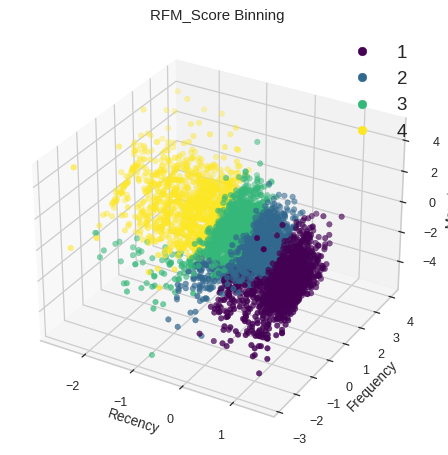

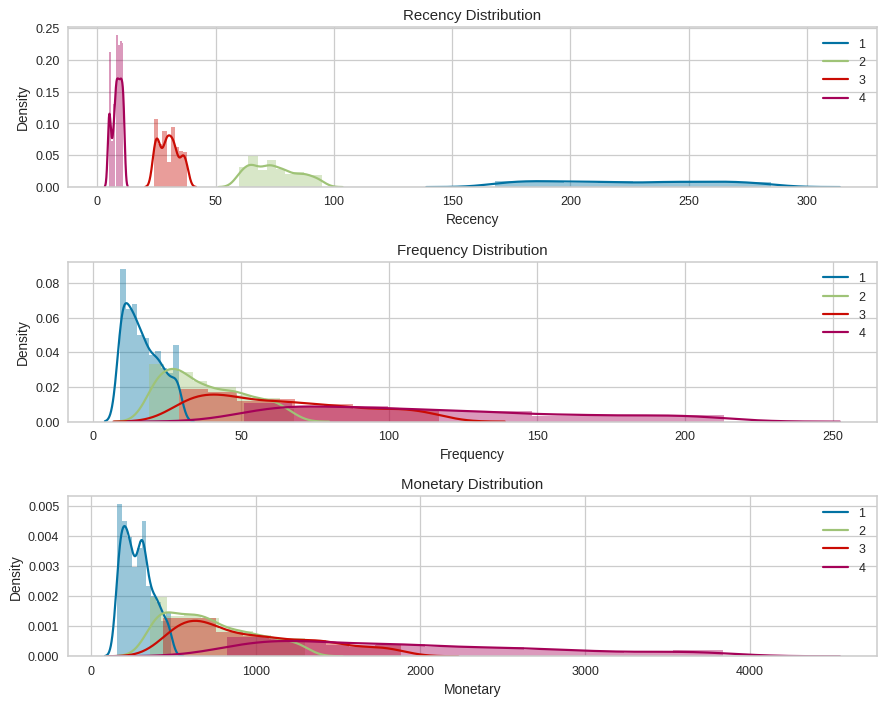

In [ ]:
# Splitting RFM_Score in 4 bins based on quantiles
y = pd.qcut(rfm['RFM'], q=4, labels=[1,2,3,4]).astype(int)

# Plotting Segments for Visualization
title = 'RFM_Score Binning'
segment_name = 'Binning'
overlap_supress = 0.25
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

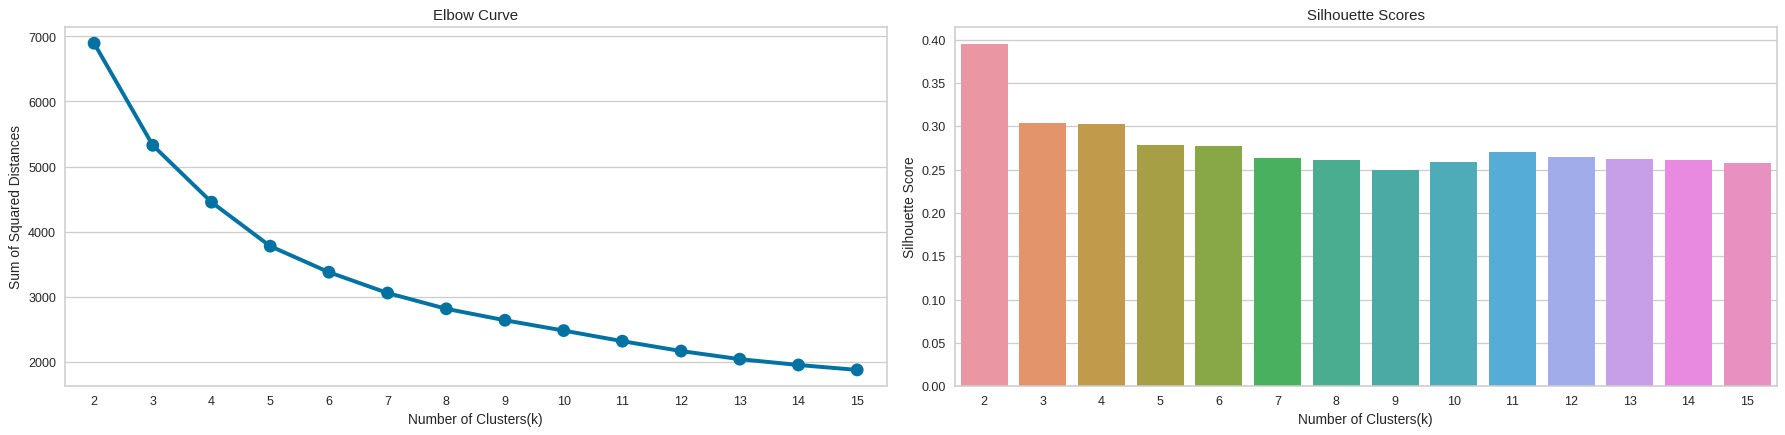

In [ ]:
# Storing sum of squared distances and Silhouette Scores for each value of k in k means clusterer
ssd,score = [],[]
# Setting figure Size
plt.figure(figsize=(20,5), dpi=90)

# Initializing the list of clusters for tuning the best clusters
n_clusters = list(range(2,16))

# Running a for loop of Kmeans algorithm
for k in n_clusters:
    clusterer = KMeans(n_clusters = k, init= 'k-means++', max_iter= 1000)
    y_preds = clusterer.fit_predict(X)                                          # Fitting the model
    ssd.append(clusterer.inertia_)                                              # Appending the inertia
    score.append(silhouette_score(X, y_preds))                                  # Appending the silhoutte score

# Plotting Elbow curve to find optimal K
plt.subplot(1, 2, 1)                                                            #Initializing subplots
sns.pointplot(x=n_clusters, y=ssd)                                              # plotting point plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Sum of Squared Distances')                                          # Setting y label
plt.title('Elbow Curve')                                                        # Setting the title

# Silhouette Score v/s Number of Clusters
plt.subplot(1, 2, 2)                                                            #Initializing subplots
sns.barplot(x=n_clusters, y=score)                                              # plotting bar plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Silhouette Score')                                                  # Setting y label
plt.title('Silhouette Scores')                                                  # Setting the title
plt.tight_layout()

Observations:
1. From the Elbow curve 5 appears to be at the elbow and hence can be considered as the number of clusters. n_clusters=4 or 6 can also be considered based of the objective of segmentation.
2. If we go by maximum Silhouette Score as the criteria for selecting optimal number of clusters, then n_clusters=2 can be chosen.
3. If we look at both of the graphs at the same time to decide the optimal number of clusters, we can take the intersection of set of good n_clusters obtained from both the graphs. So 4 appears to be a good choice, having a decent Silhouette score as well as near the elbow of the elbow curve.

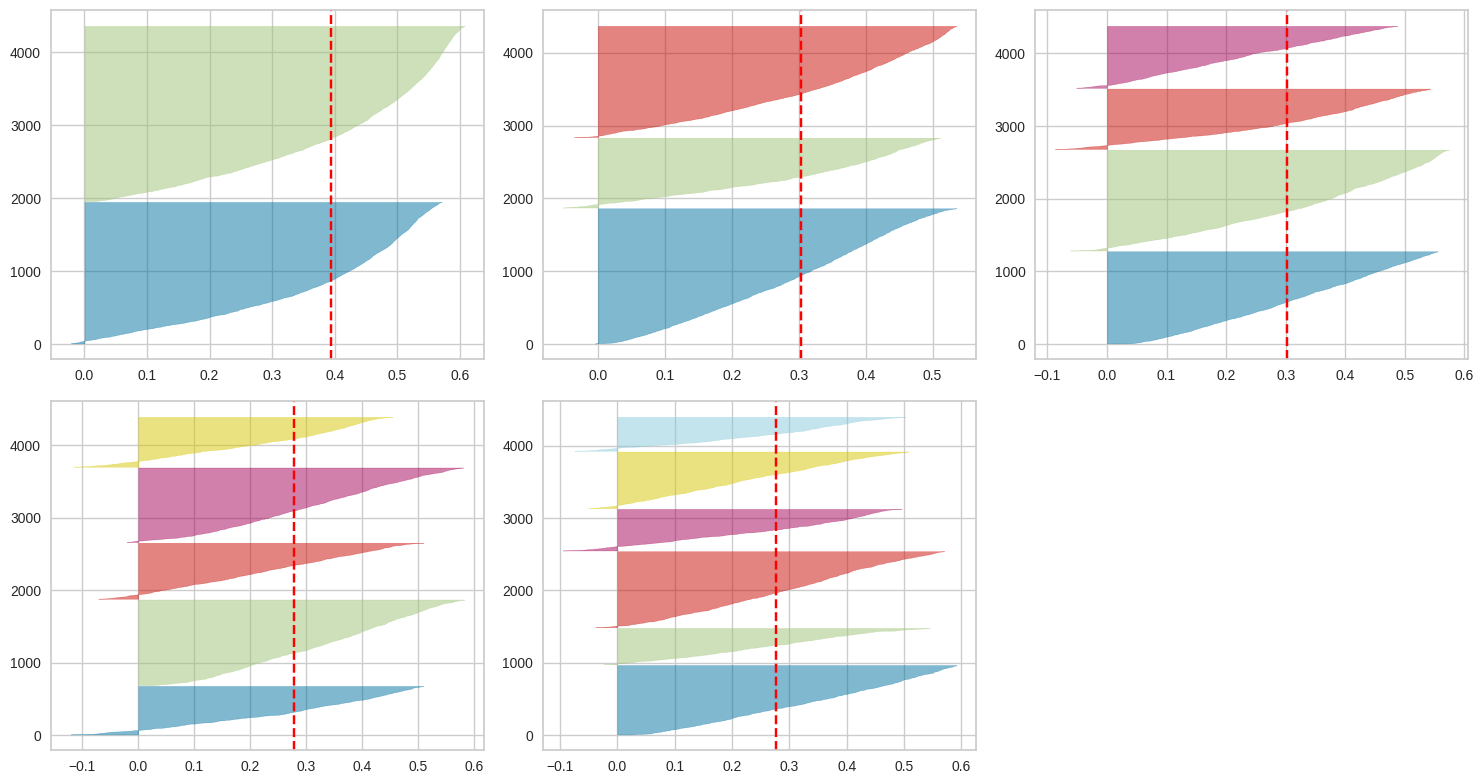

In [ ]:
# Visualizing the Silouette plots for the k-means clusters
plt.figure(figsize = (15,8))
for n,i in enumerate(range(2,7)):
    plt.subplot(2,3,n+1)
    kmeans=KMeans(i,init="k-means++")
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick')
    visualizer.fit(X)
    visualizer
    plt.tight_layout()

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



K-Means|3Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,171.170000,170.000000,14.900000,13.000000,293.010000,234.170000,181.510000,122.000000,1523
1,13.100000,9.000000,259.330000,173.000000,6543.090000,2993.100000,415.000000,443.000000,959
2,69.030000,47.000000,65.340000,52.000000,1166.470000,824.580000,288.240000,322.000000,1857


K-Means|3Cluster,Last_visited,Purchase_frequency,Money_spent
0,66 to 263 days ago,Bought 7 to 21 times,Spent around 146 to 356 Sterling
1,3 to 18 days ago,Bought 105 to 291 times,Spent around 1864 to 5185 Sterling
2,23 to 87 days ago,Bought 33 to 84 times,Spent around 542 to 1340 Sterling


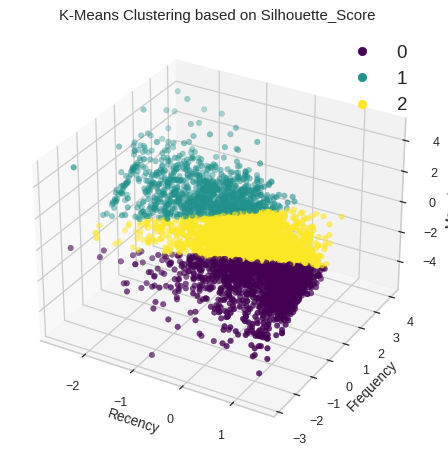

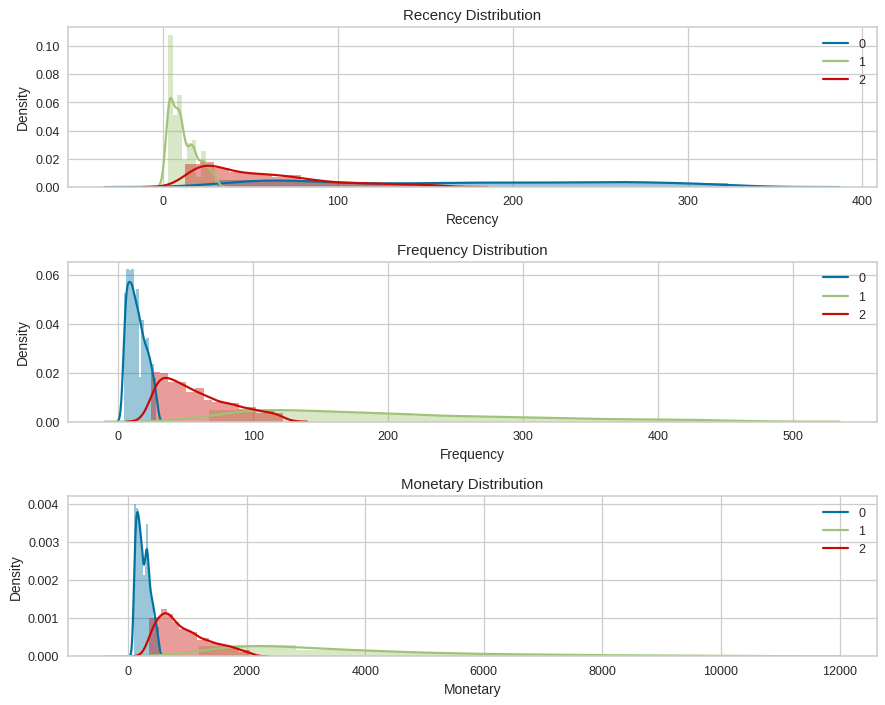

In [ ]:
# Fitting the model on n_clusters = 3 based on Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=3,init="k-means++")             # Setting 3 Clusters
y = kmc.fit_predict(X)                                  # FItting the model
centers = kmc.cluster_centers_                          # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Silhouette_Score'  # Setting the title
segment_name = 'K-Means|3Cluster'
overlap_supress = 0.1
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



K-Means|5Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,17.380000,17.000000,40.070000,34.000000,623.780000,513.010000,382.060000,412.000000,763
1,9.070000,7.000000,314.750000,212.000000,8374.980000,3803.320000,430.120000,444.000000,664
2,170.750000,170.000000,6.960000,7.000000,198.110000,152.600000,178.040000,112.000000,688
3,62.350000,46.000000,109.040000,94.500000,2043.370000,1531.910000,291.530000,333.000000,1028
4,167.710000,152.000000,30.340000,26.000000,512.870000,414.880000,175.910000,133.000000,1196


K-Means|5Cluster,Last_visited,Purchase_frequency,Money_spent
0,8 to 25 days ago,Bought 20 to 52 times,Spent around 316 to 781 Sterling
1,3 to 12 days ago,Bought 128 to 340 times,Spent around 2289 to 6480 Sterling
2,64 to 265 days ago,Bought 4 to 10 times,Spent around 103 to 215 Sterling
3,29 to 75 days ago,Bought 63 to 135 times,Spent around 1060 to 2298 Sterling
4,78 to 246 days ago,Bought 18 to 38 times,Spent around 302 to 632 Sterling


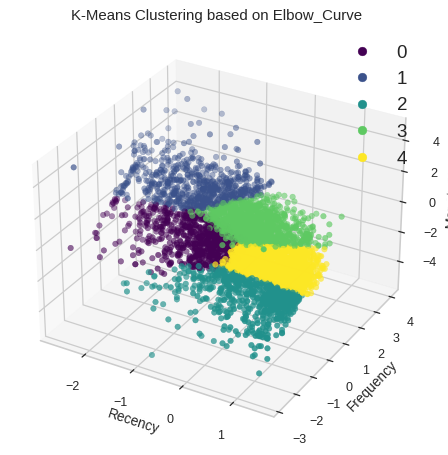

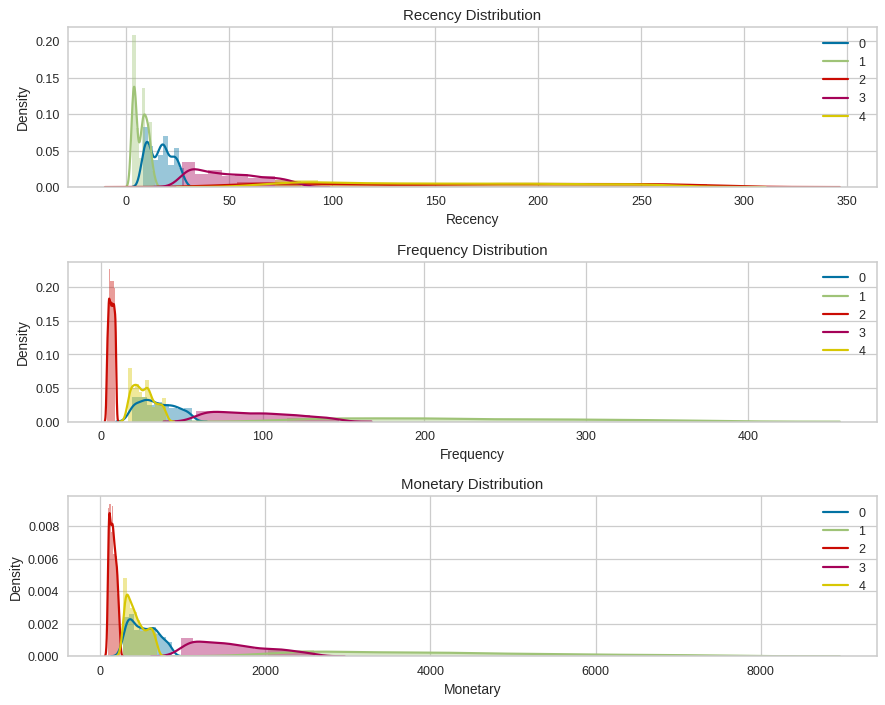

In [ ]:
# Fitting the model on n_clusters = 5 based on Elbow_Curve to visualise the segments.
kmc = KMeans(n_clusters=5,init="k-means++")           # Setting 5 Clusters
y = kmc.fit_predict(X)                                # Fitting the model
centers = kmc.cluster_centers_                        # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Elbow_Curve'     # Setting the title
segment_name = 'K-Means|5Cluster'
overlap_supress = 0.2
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



K-Means|4Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,19.500000,17.000000,38.510000,32.000000,592.050000,471.400000,375.910000,411.000000,833
1,93.590000,71.000000,80.150000,66.000000,1518.950000,1086.920000,247.020000,233.000000,1293
2,12.150000,9.000000,283.460000,193.000000,7212.440000,3347.310000,419.420000,444.000000,835
3,184.360000,184.000000,14.750000,12.500000,295.820000,240.280000,164.690000,122.000000,1378


K-Means|4Cluster,Last_visited,Purchase_frequency,Money_spent
0,9 to 28 days ago,Bought 20 to 52 times,Spent around 293 to 744 Sterling
1,43 to 120 days ago,Bought 42 to 103 times,Spent around 709 to 1706 Sterling
2,4 to 17 days ago,Bought 120 to 309 times,Spent around 2071 to 5609 Sterling
3,81 to 268 days ago,Bought 7 to 21 times,Spent around 144 to 368 Sterling


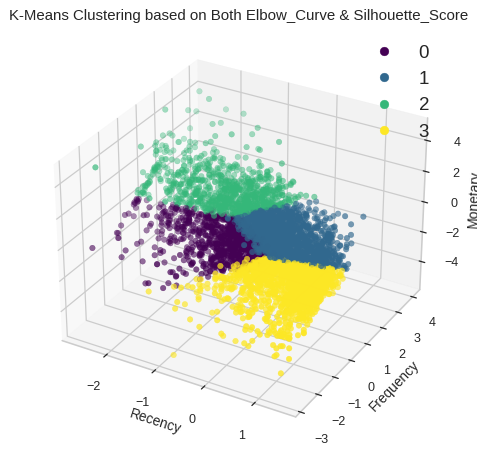

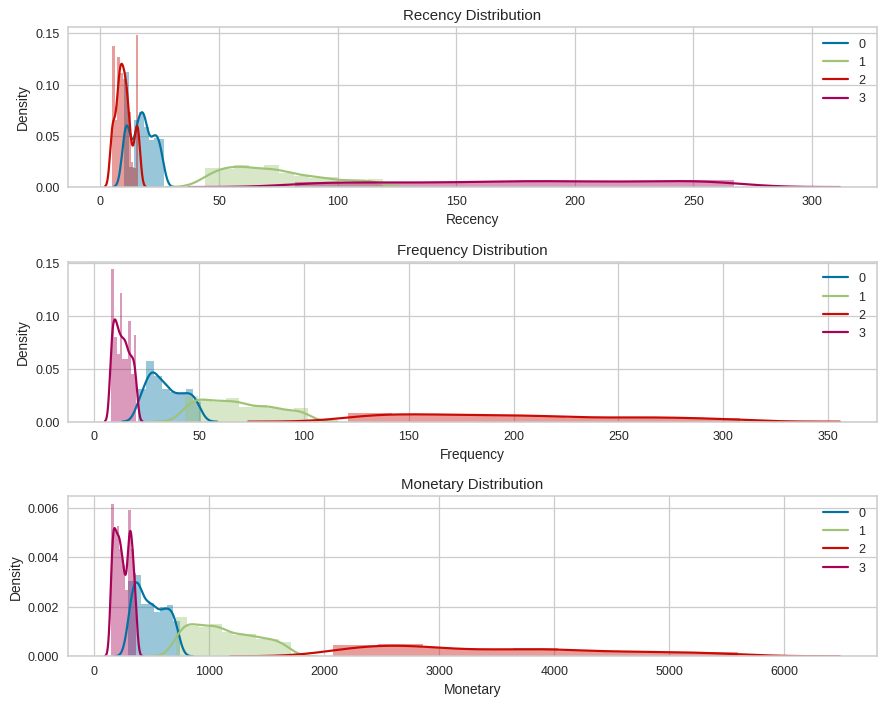

In [ ]:
# Fitting the model on n_clusters = 4 based on Both Elbow_Curve & Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=4,init="k-means++")         # Setting 4 Clusters
y = kmc.fit_predict(X)                              # Fitting the model
centers = kmc.cluster_centers_                      # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Both Elbow_Curve & Silhouette_Score'         # Setting the title
segment_name = 'K-Means|4Cluster'
overlap_supress = 0.25
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**Hierarchical Clustering**

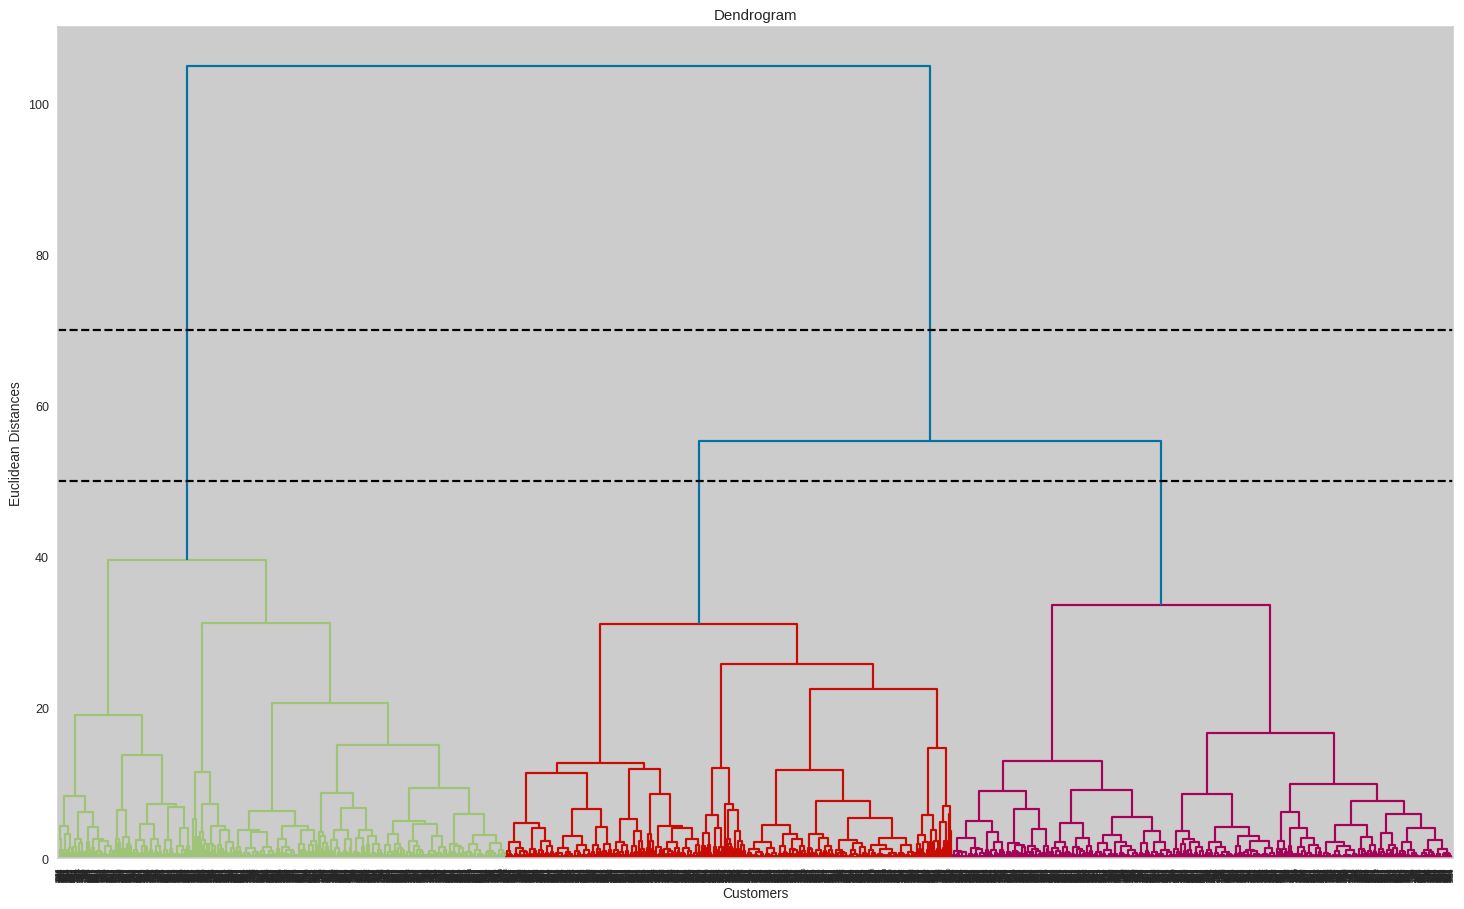

In [ ]:
# Using the Dendogram to Decide the number of clusters
plt.figure(figsize=(20,12), dpi=90)                         # Setting the figure size
dendrogram(linkage(X, method='ward'), color_threshold=50)   # using ward linkage method to differ similarities
plt.title('Dendrogram')                                     # Setting the title
plt.xlabel('Customers')                                     # Setting the x label
plt.ylabel('Euclidean Distances')                           # Setting y label
plt.axhline(y=70, color='black', linestyle='--')            # Setting the axis line for y=70
plt.axhline(y=50, color='black', linestyle='--')            # Setting the axis line for y=50
plt.show()

Observation:
1. We can set a threshold distance and draw a horizontal line (Generally, we try to set the threshold in such a way that it cuts the tallest vertical line). We can set this threshold as 50 or 70 and draw a horizontal line as shown in dendogram above.
2. The number of clusters will be the number of vertical lines which are being intersected by the line drawn using the threshold. The larger threshold (y=70) results in 2 clusters while the smaller (y=50) results in 3 clusters.



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



hierarchical|2Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,123.610000,80.000000,33.610000,25.000000,684.110000,409.680000,230.340000,222.000000,2944
1,26.910000,12.000000,210.600000,135.000000,4927.020000,2404.170000,381.060000,433.000000,1395


hierarchical|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,36 to 200 days ago,Bought 12 to 46 times,Spent around 219 to 739 Sterling
1,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling


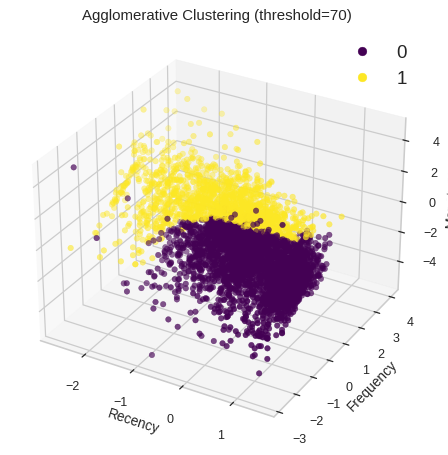

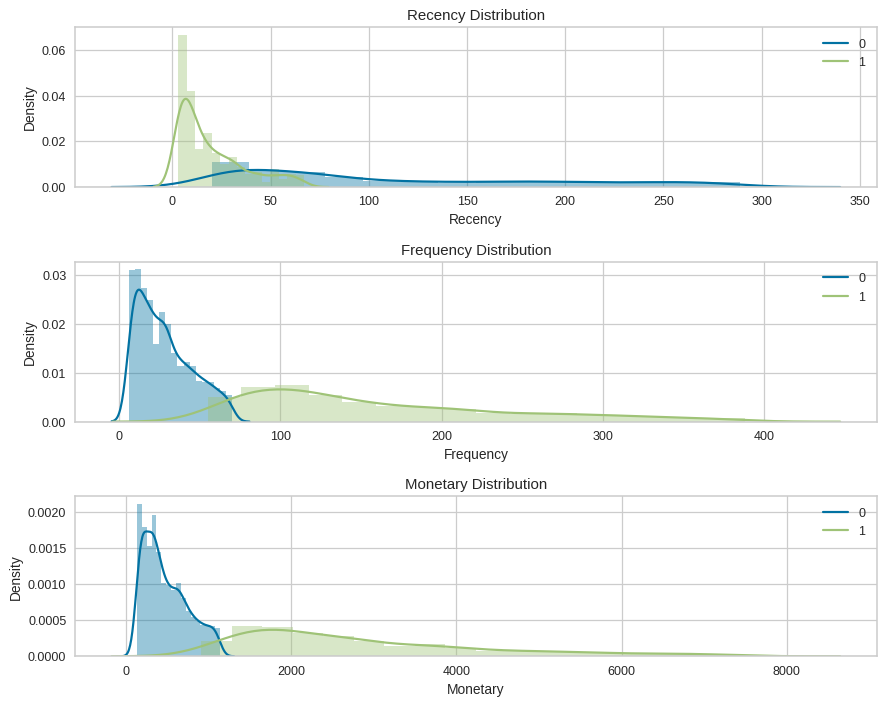

In [ ]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 70
ahc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                # Fitting and predicting the model

# Lets visualize the clusters with n_clusters = 2
title = 'Agglomerative Clustering (threshold=70)'                                     # Setting the title
segment_name = 'hierarchical|2Cluster'
overlap_supress = 0.1
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



hierarchical|3Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,26.910000,12.000000,210.600000,135.000000,4927.020000,2404.170000,381.060000,433.000000,1395
1,105.250000,71.000000,51.660000,43.000000,756.610000,657.300000,251.290000,233.000000,1559
2,144.280000,99.000000,13.300000,11.000000,602.500000,215.480000,206.750000,211.000000,1385


hierarchical|3Cluster,Last_visited,Purchase_frequency,Money_spent
0,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling
1,30 to 163 days ago,Bought 29 to 63 times,Spent around 463 to 977 Sterling
2,49 to 243 days ago,Bought 6 to 18 times,Spent around 139 to 327 Sterling


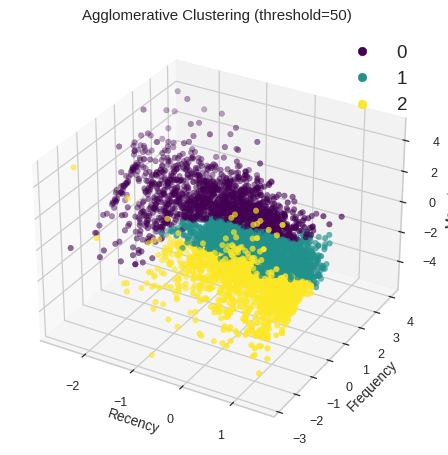

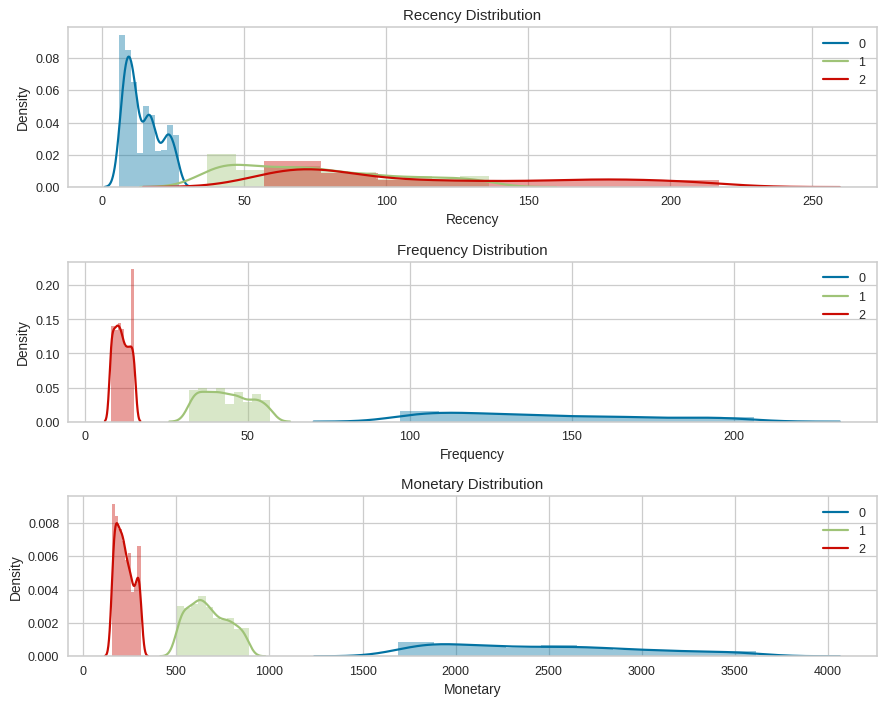

In [ ]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 50
ahc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                # Fitting and predicting the model

# Lets visualize the clusters with n_clusters = 3
title = 'Agglomerative Clustering (threshold=50)'                                     # Setting the title
segment_name = 'hierarchical|3Cluster'
overlap_supress = 0.3
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**DBScan Clusterer**



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



DBSCAN,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
-1,76.210000,32.000000,111.290000,52.000000,2591.440000,797.960000,304.230000,331.000000,3099
0,155.420000,124.000000,28.560000,25.000000,514.590000,451.440000,189.800000,221.000000,1011
1,25.250000,24.500000,73.380000,69.500000,1264.080000,1212.910000,354.550000,333.000000,154
2,56.650000,54.000000,102.290000,102.000000,1885.450000,1824.230000,271.720000,244.000000,75


DBSCAN,Last_visited,Purchase_frequency,Money_spent
-1,11 to 107 days ago,Bought 15 to 130 times,Spent around 278 to 2245 Sterling
0,66 to 245 days ago,Bought 17 to 37 times,Spent around 309 to 658 Sterling
1,19 to 30 days ago,Bought 60 to 84 times,Spent around 1052 to 1425 Sterling
2,50 to 62 days ago,Bought 89 to 114 times,Spent around 1637 to 2094 Sterling


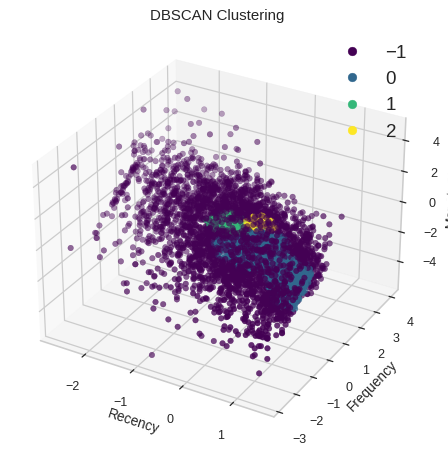

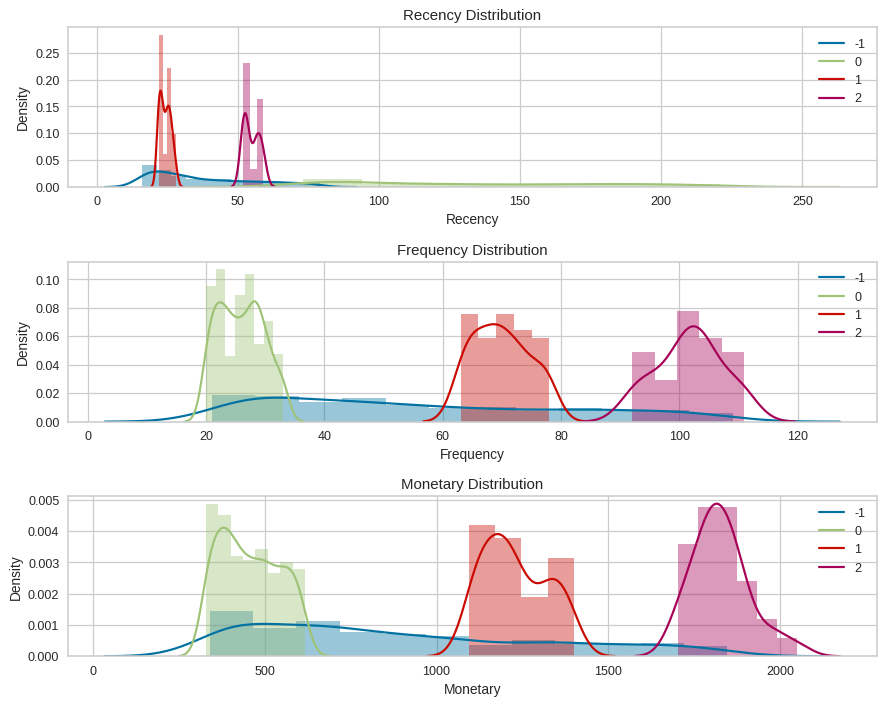

In [ ]:
# Fitting DBSCAN clusterer
dbsc = DBSCAN(eps=0.2, min_samples=25)                                # Initializing the model
y = dbsc.fit_predict(X)                                               # Fitting the model

# Plotting Clusters for Visualization
title = 'DBSCAN Clustering'                                           # Setting the title
segment_name = 'DBSCAN'
overlap_supress = 0.3
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

1. Density-based spatial clustering of applications with noise (DBSCAN) is an alternative to KMeans and hierarchical clustering. It does not require us to specify the number of clusters, as the clusters are formed by a process of linking neighbor points together.
2. It avoids outliers and identifies nested clusters within the data. The data is muddled and does not have major visible nested cluster, yet it has identified 4 clusters as shown above based on the hyperparameters defined.

##**Gaussian Mixture Model**



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



GMM,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,RFM_mean,RFM_median,Count_
0,26.400000,16.000000,145.240000,91.000000,1664.700000,911.780000,371.780000,422.000000,1302
1,60.860000,33.000000,127.070000,11.000000,8058.300000,1117.900000,308.700000,313.000000,503
2,79.180000,54.000000,69.790000,42.000000,1356.900000,757.740000,274.100000,244.000000,1638
3,230.750000,236.000000,28.340000,18.000000,495.350000,310.860000,135.460000,121.000000,896


GMM,Last_visited,Purchase_frequency,Money_spent
0,5 to 36 days ago,Bought 45 to 182 times,Spent around 406 to 2101 Sterling
1,10 to 73 days ago,Bought 4 to 50 times,Spent around 254 to 4887 Sterling
2,26 to 96 days ago,Bought 21 to 88 times,Spent around 377 to 1645 Sterling
3,169 to 291 days ago,Bought 9 to 33 times,Spent around 175 to 587 Sterling


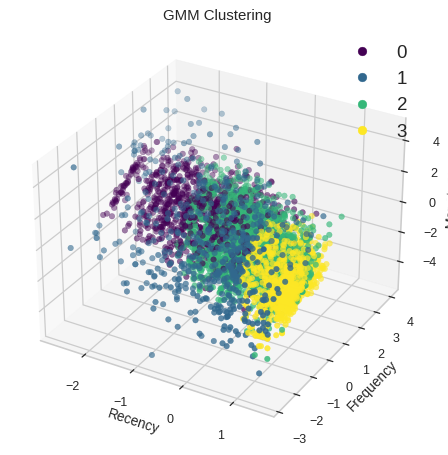

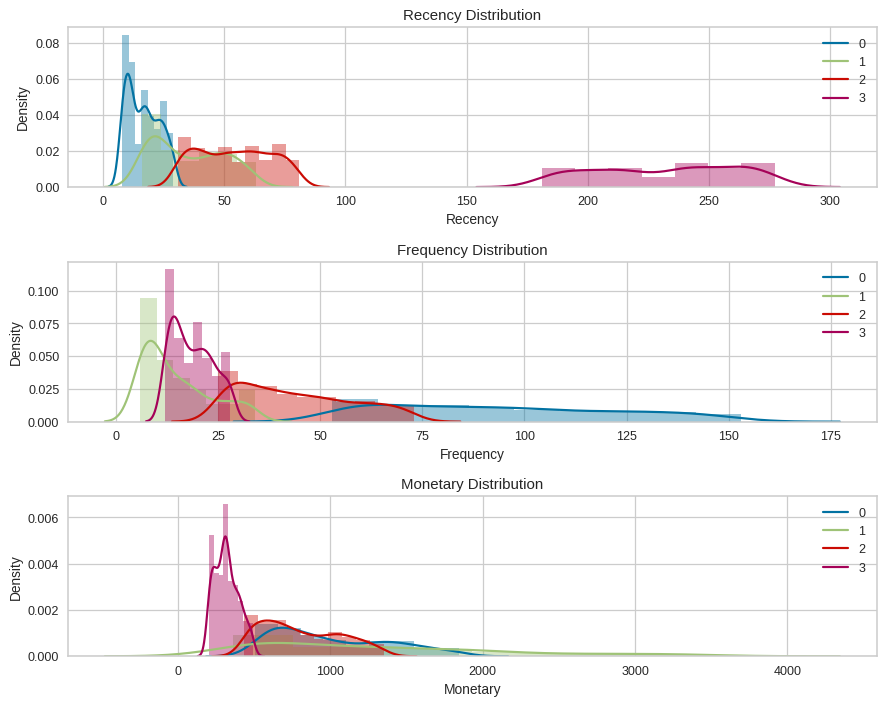

In [ ]:
# training gaussian mixture model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
y = gmm.fit_predict(X)
# Plotting Clusters for Visualization
title = 'GMM Clustering'                                           # Setting the title
segment_name = 'GMM'
overlap_supress = 0.3
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

In [ ]:
# Summarizing the results obtained by clustering using various methods
summary = pd.DataFrame({"Clusterer": ['Binning',"K-Means", "K-Means", "K-Means", "Agglomerative","Agglomerative", "DBSCAN","GMM"],
                        'Criterion': ['RFM Score Binning', 'Elbow Curve', 'Silhouette Score','Elbow Curve & Silhouette Score',
                                      'Dendogram (y=70)', 'Dendogram (y=50)', 'eps=0.2, min_samples=25','log-likelihood'],
                        "Segments" : [4,5,3,4,2,3,4,4]},
                        index=['', '', '', '', '', '', '', ''])
summary.T

,,,,,,,,
Clusterer,Binning,K-Means,K-Means,K-Means,Agglomerative,Agglomerative,DBSCAN,GMM
Criterion,RFM Score Binning,Elbow Curve,Silhouette Score,Elbow Curve & Silhouette Score,Dendogram (y=70),Dendogram (y=50),"eps=0.2, min_samples=25",log-likelihood
Segments,4,5,3,4,2,3,4,4


##**Conclusion**
1. We started with a simple binning and quantile based simple segmentation model first then moved to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.
2. Then we moved to k-means clustering and visualized the results with different number of clusters. As we know there is no assurance that k-means will lead to the global best solution. We moved forward and tried Hierarchical Clustering and DBSCAN clusterer and GMM as well.
3. We created several useful clusters of customers on the basis of different metrics and methods to cateorize the customers on the basis of their beavioural attributes to define their valuability, loyality, profitability etc for the business. Though significantly separated clusters are not visible in the plots, but the clusters obtained is fairly valid and useful as per the  algorithms and the statistics extracted from the data.
4. Segments depends on how the business plans to use the results, and the level of granularity they want to see in the clusters. Keeping these points in view we clustered the major segments based on our understanding as per diffrent criteria as shown in the summary dataframe.

In [ ]:
# Setting List of 5 types of customers based on activities of the customer
customers_type_=['LOST POOR CUSTOMERS',
                'AVERAGE CUSTOMERS',
                'RECENTLY VISITED AVERAGE CUSTOMERS',
                'GOOD CUSTOMERS',
                'BEST CUSTOMERS',
                'LOSING LOYAL CUSTOMERS']


In [ ]:
#Function to create new column of customer type
def function(x):
    if x==0:
      return 'LOST POOR CUSTOMERS'
    elif x==1:
      return 'AVERAGE CUSTOMERS'
    elif x==2:
      return 'RECENTLY VISITED AVERAGE CUSTOMERS'
    elif x==3:
      return 'GOOD CUSTOMERS'
    elif x==4:
      return 'BEST CUSTOMERS'
    else:
      return 'LOSING LOYAL CUSTOMERS'


In [ ]:
# Initializing an empty dict to store rank lists
rank_list_dict={}
def printing_conclusion(segment_name,rank_list_dict):
  # Storing the conclusion data frame into variable
  dataframe = conclusion[segment_name]
  #function to categorised customer type
  dataframe['customer_rating']=rank_list_dict[segment_name]
  dataframe['customers_type_']= dataframe['customer_rating'].apply(lambda x:function(x))
  # Displaying the conclusion dataframe
  return dataframe

Binning (4 Clusters)

In [ ]:
# Defining the segment name
segment_name = 'Binning'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [0,1,3,4]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
Binning,,,,,
1,166 to 286 days ago,Bought 8 to 30 times,Spent around 156 to 486 Sterling,0,LOST POOR CUSTOMERS
2,59 to 96 days ago,Bought 18 to 69 times,Spent around 355 to 1301 Sterling,1,AVERAGE CUSTOMERS
3,23 to 39 days ago,Bought 28 to 118 times,Spent around 439 to 1887 Sterling,3,GOOD CUSTOMERS
4,4 to 12 days ago,Bought 50 to 214 times,Spent around 822 to 3849 Sterling,4,BEST CUSTOMERS


**K-Means|3Cluster**

In [ ]:
# Defining the segment name
segment_name = 'K-Means|3Cluster'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [0,4,3]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
K-Means|3Cluster,,,,,
0,66 to 263 days ago,Bought 7 to 21 times,Spent around 146 to 356 Sterling,0,LOST POOR CUSTOMERS
1,3 to 18 days ago,Bought 105 to 291 times,Spent around 1864 to 5185 Sterling,4,BEST CUSTOMERS
2,23 to 87 days ago,Bought 33 to 84 times,Spent around 542 to 1340 Sterling,3,GOOD CUSTOMERS


**K-Means|4Cluster**

In [ ]:
# Defining the segment name
segment_name = 'K-Means|4Cluster'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [0,2,4,5]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
K-Means|4Cluster,,,,,
0,9 to 28 days ago,Bought 20 to 52 times,Spent around 293 to 744 Sterling,0,LOST POOR CUSTOMERS
1,43 to 120 days ago,Bought 42 to 103 times,Spent around 709 to 1706 Sterling,2,RECENTLY VISITED AVERAGE CUSTOMERS
2,4 to 17 days ago,Bought 120 to 309 times,Spent around 2071 to 5609 Sterling,4,BEST CUSTOMERS
3,81 to 268 days ago,Bought 7 to 21 times,Spent around 144 to 368 Sterling,5,LOSING LOYAL CUSTOMERS


**K-Means|5Cluster**

In [ ]:
# Defining the segment name
segment_name = 'K-Means|5Cluster'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [4,0,5,1,3]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
K-Means|5Cluster,,,,,
0,8 to 25 days ago,Bought 20 to 52 times,Spent around 316 to 781 Sterling,4,BEST CUSTOMERS
1,3 to 12 days ago,Bought 128 to 340 times,Spent around 2289 to 6480 Sterling,0,LOST POOR CUSTOMERS
2,64 to 265 days ago,Bought 4 to 10 times,Spent around 103 to 215 Sterling,5,LOSING LOYAL CUSTOMERS
3,29 to 75 days ago,Bought 63 to 135 times,Spent around 1060 to 2298 Sterling,1,AVERAGE CUSTOMERS
4,78 to 246 days ago,Bought 18 to 38 times,Spent around 302 to 632 Sterling,3,GOOD CUSTOMERS


**hierarchical|2Cluster**

In [ ]:
# Defining the segment name
segment_name = 'hierarchical|2Cluster'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [1,4]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
hierarchical|2Cluster,,,,,
0,36 to 200 days ago,Bought 12 to 46 times,Spent around 219 to 739 Sterling,1,AVERAGE CUSTOMERS
1,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling,4,BEST CUSTOMERS


**hierarchical|3Cluster**

In [ ]:
# Defining the segment name
segment_name = 'hierarchical|3Cluster'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [4,5,0]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)


,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
hierarchical|3Cluster,,,,,
0,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling,4,BEST CUSTOMERS
1,30 to 163 days ago,Bought 29 to 63 times,Spent around 463 to 977 Sterling,5,LOSING LOYAL CUSTOMERS
2,49 to 243 days ago,Bought 6 to 18 times,Spent around 139 to 327 Sterling,0,LOST POOR CUSTOMERS


**DBSCAN**

In [ ]:
# Defining the segment name
segment_name = 'DBSCAN'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [1,0,3,5]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
DBSCAN,,,,,
-1,11 to 107 days ago,Bought 15 to 130 times,Spent around 278 to 2245 Sterling,1,AVERAGE CUSTOMERS
0,66 to 245 days ago,Bought 17 to 37 times,Spent around 309 to 658 Sterling,0,LOST POOR CUSTOMERS
1,19 to 30 days ago,Bought 60 to 84 times,Spent around 1052 to 1425 Sterling,3,GOOD CUSTOMERS
2,50 to 62 days ago,Bought 89 to 114 times,Spent around 1637 to 2094 Sterling,5,LOSING LOYAL CUSTOMERS


##**GMM**

In [ ]:
# Defining the segment name
segment_name = 'GMM'

# Manually Rating stars for the groups of customer
rank_list_dict[segment_name] = [4,2,3,0]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name,rank_list_dict)

,Last_visited,Purchase_frequency,Money_spent,customer_rating,customers_type_
GMM,,,,,
0,5 to 36 days ago,Bought 45 to 182 times,Spent around 406 to 2101 Sterling,4,BEST CUSTOMERS
1,10 to 73 days ago,Bought 4 to 50 times,Spent around 254 to 4887 Sterling,2,RECENTLY VISITED AVERAGE CUSTOMERS
2,26 to 96 days ago,Bought 21 to 88 times,Spent around 377 to 1645 Sterling,3,GOOD CUSTOMERS
3,169 to 291 days ago,Bought 9 to 33 times,Spent around 175 to 587 Sterling,0,LOST POOR CUSTOMERS


##**Overall Cluster Summary**

In [ ]:
# creating a dataframe to show the segments obtained by each method
print("Customer Segments Obtained From Clustering Analysis")
final_df = pd.DataFrame()
for segment_name in rank_list_dict:
  value = ["Yes" if j in rank_list_dict[segment_name] else "No" for j in range(6)]
  final_df[segment_name] = pd.Series(value, index=customers_type_)
final_df.T

Customer Segments Obtained From Clustering Analysis


,LOST POOR CUSTOMERS,AVERAGE CUSTOMERS,RECENTLY VISITED AVERAGE CUSTOMERS,GOOD CUSTOMERS,BEST CUSTOMERS,LOSING LOYAL CUSTOMERS
Binning,Yes,Yes,No,Yes,Yes,No
K-Means|3Cluster,Yes,No,No,Yes,Yes,No
K-Means|4Cluster,Yes,No,Yes,No,Yes,Yes
K-Means|5Cluster,Yes,Yes,No,Yes,Yes,Yes
hierarchical|2Cluster,No,Yes,No,No,Yes,No
hierarchical|3Cluster,Yes,No,No,No,Yes,Yes
DBSCAN,Yes,Yes,No,Yes,No,Yes
GMM,Yes,No,Yes,Yes,Yes,No
